<a href="https://colab.research.google.com/github/MJ-best/StudyNote_TimeSerise_AnormalyDetection/blob/main/%5B%ED%8C%A8%EC%8A%A4%ED%8A%B8%EC%BA%A0%ED%8D%BC%EC%8A%A4_%EC%9D%B4%EC%83%81%ED%83%90%EC%A7%80%EA%B8%B0%EB%B2%95%5D%EC%9D%B4%EC%83%81%EC%9D%84_%ED%83%90%EC%A7%80%ED%95%98%EB%8A%94_%EC%97%AC%EB%9F%AC_%EB%B0%A9%EB%B2%95%EB%A1%A0%EB%93%A4_20230124.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **<font color=pink> 🛑 25개 사례로 배우는 Anomaly Detection 알고리즘 구현과 실전 프로젝트 Online**
<font color=pink>┗ Part2. 이상을 탐지하는 여러 방법론들
---

> **(1) 통계적 기법**

> **(2) 거리·밀도 기반 이상 탐지**

> **(3) 분류 모델 기반 이상 탐지**

> **(4) 차원축소·시각화 기반 이상 탐지**

> **(5) 기업(twitter, amazone) 알고리즘 기반 이상 탐지**

> **(6) 시계열 분해 기반 이상 탐지**

<font color=gray>※ 개념 및 Toy data 활용 실습 구성


In [1]:
# ▶ Warnings 제거
import warnings
warnings.filterwarnings('ignore')

## Ch01-(1). 🎯 3-sigma Rule 이상탐지
___

* 정의
```
# σ란 보통 통계학에서 오차범위를 의미하고 경영학에서는 제품의 불량률(품질)을 나타내는데 사용한다
# 1σ는 68% / 3σ는 99.7% / 6σ 99.9996%의 제품이 만족스럽다는 의미가 된다.
# SPC(Statistical Process Control, 통계적 공정관리), 경험적 규칙(empirical rule)
# 표준편차의 3배인 3*Sigma(σ)의 범위가 전체 Data의 99.7%를 포함
# Data 전체의 산포를 파악하는 개념으로 많이 활용됨
# UCL(Upper Control Limit) / LCL(Lower Control Limit)
```
<img src = "https://drive.google.com/uc?id=1iX8VeZrJADyEf1hwYiNb4JX2HhpBTra2">

* 특징
```
# 공정관리에서 주로 쓰이는 룰
# 제조공정에서 주로 사용 된다
# 조금더 빡빡하게 계산을 하겠다라고 하면 2시그마로 기준을 잡을 수도 있음
```

* 장단점
```
  # [good] 매우 구현하기 쉬움
  # [good] 명확한 기준을 설정할 수 있기 때문에, 방법론에 재학습이 필요없음(하이퍼파라미터가 없음! 굳이 따지자면 σ계수)
  # [bad] 정규분포가 가정되어야 함, 꼬리가 치우쳐있으면 명확하게 분석을 할 수 없다.
  # [bad] 다차원 데이터에 적용하기 어려움
  # [bad] 단변량 데이터에 적용할 수 있으며, Feature간 상호관계를 파악하기 어려움
```
  
* 사용방법
```
# 데이터의 분포를 정규분포로 가정하고, 평균으로부터 (표준편차 x 시그마 계수σ)를 벗어나면 아웃라이어라고 판단함
# 시그마 계수(σ)
```

* 현업사례
```
# 공정 센서 데이터 이상탐지
# 검사 및 측정 데이터 이상탐지 
```
   


### Ch01-(1). ✍ Toy data 실습
___

In [2]:
# ▶ Toy data 생성
import numpy as np
import pandas as pd 
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',100)

df = pd.DataFrame({"name": ['KATE', 'LOUISE', 'JANE', 'JASON', 'TOM', 'JACK'], 
                   "weight": ['59', '61', '55', '66', '52', '110'], 
                   "height": ['120', '123', '115', '145', '64', '20']})
df

,name,weight,height
0,KATE,59,120
1,LOUISE,61,123
2,JANE,55,115
3,JASON,66,145
4,TOM,52,64
5,JACK,110,20


- 실제로 적용할 때에는 데이터가 정규성을 보이고 있는지를 먼저 시각화를 통해 검증한 다음에 3시그마 알고리즘을 사용해야 한다

In [3]:
# ▶ data type 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    6 non-null      object
 1   weight  6 non-null      object
 2   height  6 non-null      object
dtypes: object(3)
memory usage: 272.0+ bytes


In [4]:
# ▶ 숫자형 데이터로 변경
df['weight'] = df['weight'].astype(int)
df['height'] = df['height'].astype(int)

- 데이터의 평균을 중심으로 잡고, 표준편차로 시그마를 설정해줬다.
- 평균 : df['weight'].mean()
- 시그마 : df['weight'].std()
- 정상 범주안에 들어오는 데이터 : 평균 - 2시그마 ~ 평균 + 2시그마


In [5]:
# ▶ UCL, LCL 생성
df['UCL_W'] = df['weight'].mean() + 2*df['weight'].std()
df['LCL_W'] = df['weight'].mean() - 2*df['weight'].std()

df['UCL_H'] = df['height'].mean() + 2*df['height'].std()
df['LCL_H'] = df['height'].mean() - 2*df['height'].std()

In [6]:
# ▶ data 확인
df

,name,weight,height,UCL_W,LCL_W,UCL_H,LCL_H
0,KATE,59,120,110.237152,24.096182,190.986254,4.680412
1,LOUISE,61,123,110.237152,24.096182,190.986254,4.680412
2,JANE,55,115,110.237152,24.096182,190.986254,4.680412
3,JASON,66,145,110.237152,24.096182,190.986254,4.680412
4,TOM,52,64,110.237152,24.096182,190.986254,4.680412
5,JACK,110,20,110.237152,24.096182,190.986254,4.680412


- 그래프를 통해 아웃라이어가 있는지를 직관적으로 확인한다

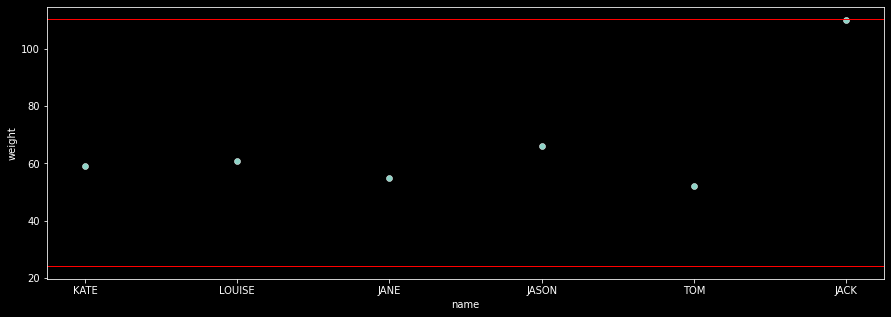

In [7]:
# ▶ weight plot 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use(['dark_background'])

sns.scatterplot(x=df['name'], y=df['weight']);
plt.axhline(y=df['UCL_W'][0], color='r', linewidth=1)
plt.axhline(y=df['LCL_W'][0], color='r', linewidth=1)
plt.gcf().set_size_inches(15, 5)

- JACK의 몸무게가 이상치에 가깝게 나타난다

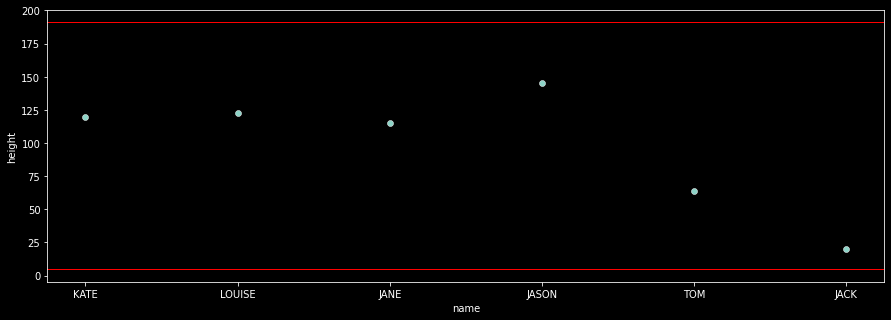

In [8]:
# ▶ height plot 
sns.scatterplot(x=df['name'], y=df['height']);
plt.axhline(y=df['UCL_H'][0], color='r', linewidth=1)
plt.axhline(y=df['LCL_H'][0], color='r', linewidth=1)
plt.gcf().set_size_inches(15, 5)

- JACK과 TOM이 이상치에 가깝게 나타난다

-  이상치를 포함해서 평균을 계산하기 때문에 이상치가 너무 벌어져있게 되면 이상치 탐색이 어렵다. 즉 아웃라이어 값에 민감하다는 단점이 있다

## Ch01-(1). 🎯 Box plot 이상탐지
___
* 정의
```
# 많은 데이터를 눈으로 확인하기 어려울 때 그림을 이용해 데이터 집합의 범위와 중앙값을 빠르게 확인
# Box plot은 최소 정상값(min), 1사분위수(Q1), 중앙값, 3사분위수(Q3), 최대 정상값(max)를 나타내는 시각화 방법
```
<img src = "https://drive.google.com/uc?id=1pQT3D1JhZXEL5Cc79fZJAd5F3LORGezM">

* 특징
```
# 현업에서 아직도 많이 사용
# EDA를 할 때 많이 사용함
# 통계적 기반의 방법론이기 때문에 근거가 필요한 공정에서 많이 사용된다 
```

* 장단점
```
  # [good] 데이터를 눈으로 확인하기 어려울 때, 그림을 이용해 데이터의 범위를 빠르게 파악
  # [good] 통계적으로 이상치(Outlier)가 있는지 확인 가능
  # [good] 다양한 정보를 손쉽게 표현할 수 있음
  # [bad] 위치정보에 기반하고 있기 때문에 분포를 확인하기는 어려움
  # [bad] 가운데 선은 평균이 아니다. 오해 소지가 있음
```
  
* 사용방법
```
# 주어진 데이터에서 각 사분위수를 계산한다.
# 그래프에서 제 1사분위수와 제 3사분위수를 기준으로 박스를 그린다.
# 제 2사분위수에 해당하는 위치에 선을 긎는다.
# 제 3사분위수에서 1.5IQR을 더한 위치에 가로 선을 긎고 제 3사분위수부터 가로선까지 세로선을 긎는다.
# 제 1사분위수에서 1.5IQR을 뺀 위치에 가로 선을 긎고 제 1사분위수부터 가로선까지 세로선을 긎는다.
#4,5번에 그은 직선을 넘어서는 위치에 존재하는 값은 동그라미와 같은 기호로 표시한다.(이상치 의미) 
```

* 용어
```
# median - 중앙값
# IQR : 25% ~ 75%에 해당한 부분 
# 75th Percentile : 제 3사분위수
# 25th Percentile : 제 1사분위수
# Whisker : 최댓값, 최솟값
# Outlier : 이상치 (Q3+1.5 IQR, Q1-1.5 IQR)
```

* 현업사례
```
# EDA 단계에서 많이 사용됨
# 공정 센서 데이터 이상탐지
# 검사 및 측정 데이터 이상탐지 
```
   


### Ch01-(1). ✍ Toy data 실습
___

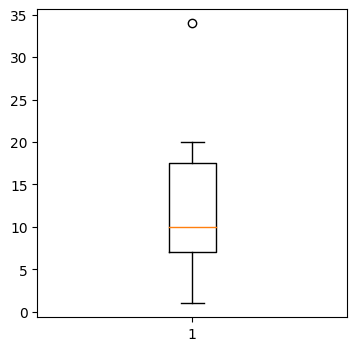

In [9]:
# ▶ Box plot 그려보기
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use(['default'])

test = pd.DataFrame([1, 5, 9, 10 ,15, 20, 34])
fig, ax = plt.subplots(1,1, figsize=(4,4))
a = list(test[0])
box = ax.boxplot(a);

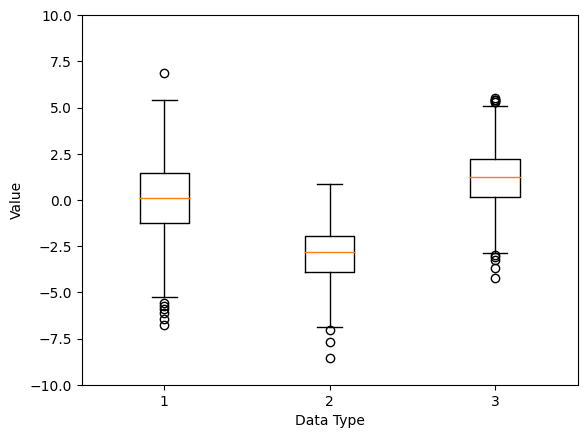

In [10]:
# ▶ Box plot 그려보기
import numpy as np
# plt.style.use(['default'])

data_a = np.random.normal(0, 2.0, 1000)
data_b = np.random.normal(-3.0, 1.5, 500)
data_c = np.random.normal(1.2, 1.5, 1500)

labels = ['data_a', 'data_b', 'data_c']

fig, ax = plt.subplots() ;

box = ax.boxplot([data_a, data_b, data_c], whis=1.5);
# whis는 데이터에 따라 임의로 설정할 수 있다. whis에 따라 아웃라이어 탐색가능
ax.set_ylim(-10.0, 10.0);
ax.set_xlabel('Data Type');
ax.set_ylabel('Value');

- 분포를 알기 힘들다는 단점을 산점도 데이터를 함께 그려서 보완

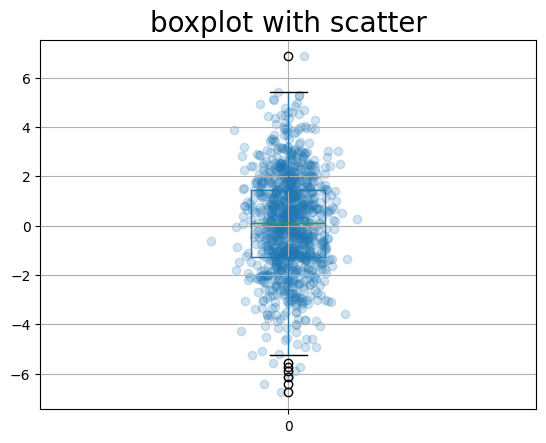

In [11]:
# ▶ Box plot, 분포를 확인하기 어려울 때 다음 Plot을 활용함 
data_a_df = pd.DataFrame(data_a)
data_a_df.boxplot()
 
# ▶ matplotlib을 이용하여 그 위에 각 점들을 찍어줌
for i, d in enumerate(data_a_df):
    y = data_a_df[d]
    x = np.random.normal(i + 1, 0.04, len(y))
    plt.scatter(x, y, alpha = 0.2)
plt.title("boxplot with scatter", fontsize=20)    
plt.show()

In [12]:
# ▶ Outlier 검출하기
def get_box_plot_data(labels, bp):
    rows_list = []
    for i in range(len(labels)):
        dict1 = {}
        dict1['label'] = labels[i]
        dict1['lower_whisker'] = bp['whiskers'][i*2].get_ydata()[1]
        dict1['lower_quartile'] = bp['boxes'][i].get_ydata()[1]
        dict1['median'] = bp['medians'][i].get_ydata()[1]
        dict1['upper_quartile'] = bp['boxes'][i].get_ydata()[2]
        dict1['upper_whisker'] = bp['whiskers'][(i*2)+1].get_ydata()[1]
        dict1['Outlier'] = bp['fliers'][i].get_ydata()
        rows_list.append(dict1)

    return pd.DataFrame(rows_list)

In [13]:
# ▶ Box plot summary
get_box_plot_data(labels, box)

,label,lower_whisker,lower_quartile,median,upper_quartile,upper_whisker,Outlier
0,data_a,-5.255649,-1.271118,0.099175,1.461940,5.433569,"[-5.744207336661413, -6.42850065018726, -5.589..."
1,data_b,-6.863373,-3.926973,-2.816535,-1.932680,0.864871,"[-7.697713352713222, -7.051114918487258, -8.54..."
2,data_c,-2.877553,0.140732,1.228007,2.197119,5.089711,"[-4.2467086204906135, -3.6969545208447228, -2...."


In [14]:
# ▶ Box plot Outlier 객체 출력
fliers = [item.get_ydata() for item in box['fliers']]
fliers

[array([-5.74420734, -6.42850065, -5.58978571, -5.87836072, -6.76905874,
        -6.1368152 ,  6.8608163 ]),
 array([-7.69771335, -7.05111492, -8.54085529]),
 array([-4.24670862, -3.69695452, -2.98469099, -3.07795647, -3.23622937,
         5.30424767,  5.40331333,  5.42148307,  5.29992484,  5.49976988,
         5.39478834])]

In [15]:
fliers[1]

array([-7.69771335, -7.05111492, -8.54085529])

## Ch02-(1). 🎯 마할라노비스 거리 이상 탐지
___
* 정의
```
# 중심점까지의 거리를 기준으로 이상치를 식별하는 방법 
# 기존에 알고있는 유클리드 거리에 공분산 계산이 더해진 개념 (※ 변수들간 Correlation을 고려)
# Mahalanobis Distance(MD)를 사용하여 점과 분포 사이의 거리를 찾는 방법
# 변수의 공분산 행렬을 사용하여 데이터 점과 중심 사이의 거리를 찾음
# 다변량 데이터에서 매우 효과적으로 작동
# 대표적인 Centroid 방법론인 유클리드 거리와 달리 데이터의 분포 패턴을 기반으로 이상치를 감지
```
<img src = "https://drive.google.com/uc?id=1Oi_NNTLKETm0BKb81_CQ6XyQP4uHIHAB">

* 장단점
```
  # [good] 데이터의 분포를 고려한 이상치 탐지 가능 
  # [good] 비선형 관계의 데이터에 활용 가능
  # [good] 데이터에 자체에 대한 가정이 필요 없음
  # [bad] 변수간의 관계가 모두 독립이라면 유클리드 거리와 같은 개념 (Correlation이 없으므로, 하지만 완벽한 독립인 데이터는 없다)
  # [bad] 변수간의 상관성이 명확이 알려져 있지 않은 경우 적용하기 어려움
  # [bad] 데이터가 여러 클러스터를 이루는 경우에는 잘 작동하지 않음
```
  
* 사용방법
```
# 일반적으로 outlier detection은 알려진 일정한 분포(gaussian distiributed)로부터 정상적인 데이터를 추정
# Covariance.EllipticEnvelolpe를 사용하여 공분산 추정을 하고, 중심 데이터들을 타원형에 fit
# Threshold(기준치)를 설정하고, Outlier를 검출
```

* 현업사례
```
# 일정한 품질로 제품을 생산하는 공정에서 이상 제품 탐지
# 값들이 일정하게 있으면서 다변량의 조건들이 작용하는 상황에서 응용!
# 2차전지(배터리), 태양열 Cell 등
```
   

### Ch02-(1). ✍ Toy data 실습
___

In [117]:
import pandas as pd
import numpy as np

# ▶ 정규 분포를 이용하여 데이터 분포에 타원을 그림, 타원에서 벗어날수록 outlier
from sklearn.covariance import EllipticEnvelope
# ▶ 랜덤 데이터를 생성하는데 사용됩니다. (※ 모든 방향으로 같은 성질을 가지는 정규분포를 이용해 가상 데이터 생성 클러스링 용 가상데이터를 생성하는데 사용)
from sklearn.datasets import make_blobs

# ▶ 랜덤 데이터 생성
X, _ = make_blobs(n_samples = 1000,
                  n_features = 2,
                  centers = 1,
                  random_state = 1)

# ▶ 이상치 Input
X[0,0] = 10
X[0,1] = -10 

# ▶ EllipticEnvelope 을 이용하여 outlier를 검출하기 위한 객체를 생성합니다.
# contamination은 이상치 탐색에서 계속 나오는 하이퍼파라미터, 이상치의 쓰레솔드를 의미
# ▶ The amount of contamination of the data set, i.e. the proportion of outliers in the data set
outlier_detector = EllipticEnvelope(contamination=.1)

# ▶ EllipticEnvelope 객체를 생성한 데이터 학습
outlier_detector.fit(X)

# ▶ outlier를 검출
# ▶ +1 이면 boundary 안에 들어온 값으로 정상 데이터
# ▶ -1 이면 outlier로 간주.
pred = outlier_detector.predict(X)
pred

array([-1,  1, -1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1, -1,
        1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1,  1,  1,
        1,  1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1, -1,  1,  1,  1,  1,  1, -1,  1,  1, -1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1, -1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1, -1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
       -1,  1,  1,  1,  1

In [118]:
outlier_detector.dist_


array([3.68590472e+02, 1.99810648e+00, 1.06468354e+01, 1.62794016e+00,
       2.80011173e+00, 3.63740700e+00, 2.79164008e-01, 7.33542877e-01,
       1.98966356e+00, 1.63154634e+00, 7.12450558e+00, 1.90214246e+00,
       6.53283186e-01, 4.33288972e-01, 3.13971768e+00, 4.65300223e+00,
       5.90257802e+00, 1.31007300e+00, 3.49152510e+00, 1.79775740e+00,
       2.55979218e+00, 1.17570299e+00, 5.14102956e+00, 6.71300622e-01,
       6.20382832e+00, 1.11112084e+00, 1.45321059e-01, 3.03059995e-01,
       1.46509313e+00, 1.40886176e-01, 1.88891734e+00, 1.72043917e-01,
       1.99568458e+00, 3.33892701e-01, 2.81645634e-01, 2.07229028e+00,
       1.36802579e+00, 1.53590398e-01, 2.94936510e-01, 2.56610641e+00,
       3.11011466e+00, 1.55940405e+00, 2.55301919e+00, 2.20480697e+00,
       9.14141823e+00, 6.22762461e-02, 2.62151814e+00, 7.44860680e-01,
       1.14067621e-01, 1.30556872e+00, 2.55883513e+00, 1.66632959e+00,
       7.58415582e-01, 1.39527020e+00, 1.29223640e+00, 9.72247570e-01,
      

In [119]:
# ▶ Raw data + Pred data
df = pd.DataFrame(X, columns=['col1', 'col2'])
df['outlier'] = pred
df.head(10)

,col1,col2,outlier
0,10.000000,-10.000000,-1
1,-0.271586,4.632690,1
2,1.371297,5.231074,-1
3,-1.001023,5.405392,1
4,-3.233633,4.507083,1
5,-3.084421,3.503047,1
6,-2.107033,4.595073,1
7,-2.107883,5.099179,1
8,-0.619471,3.488050,1
9,-2.573003,3.782585,1


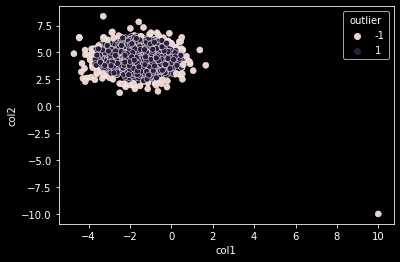

In [120]:
# ▶ Plot
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use(['dark_background'])

sns.scatterplot(x='col1', y='col2', hue='outlier', data=df);

## Ch02-(2). 🎯 KNN 이상 탐지
___
* 정의
```
# KNN(K-Nearest_Neighbors), K개의 이웃한 데이터를 기반으로 대상을 분류
# 데이터를 가장 가까운 유사 속성에 따라 분류하는 알고리즘
# 지도학습(Supervised Learning)에 한 종류로 거리기반 분류 모델 (위의 박스플롯, 3시그마, 마할라노비스는 비지도학습 방식)
# 데이터로부터 거리가 가까운 'K'개의 다른 데이터의 레이블을 참조하여 분류하는 알고리즘
# 관심있는 데이터와 인접한 K개의 데이터를 찾아, 해당 데이터의 라벨이 다수인 범주로 데이터를 분류하는 방법
```
<img src = "https://drive.google.com/uc?id=13U0rUJ2WwkR4s1HZvz_zwXtlScmfFW70" width="300" height="400">

* 특징
```
# 지도학습에서 사용해야 한다
# 연산량이 많기 때문에 어느정도 연산 자원이 있어야 사용할 수 있다(모든 포인트간 관계를 계산하므로)
# EDA & 베이스라인을 잡을때 주로 사용 (작은 데이터셋)
```

* 장단점
```
  # [good] 기존 분류 체계 값을 모두 검사하여 비교하므로 높은 정확도 
  # [good] 단순하고 효율적
  # [good] 수치 기반 데이터 분류 작업에서 성능 우수
  # [good] 기존 데이터를 기반으로 하기 때문에 데이터에 대한 가정(정규분포 등)이 없음
  # [bad] 기존의 모든 데이터를 비교해야 하기 때문에 데이터가 많으면 많을 수록 처리 시간이 증가 
  # [bad] 특징과 클래스간 관계를 이해하는데 제한적
  # [bad] 카테고리컬 데이터를 위한 추가 처리가 필요 (엥간하면 수치형 데이터에서 사용)
  # [bad] 대부분의 이상탐지에선 지도학습을 할 수 있는 레이블이 없다
```
  
* 사용방법
```
# PyOD(Python Outlier Detection) 패키지 활용, 이상탐지 알고리즘이 정리된 패키지
# K 개수 결정 (※ 이외에 다양한 Hyper parameter 결정, 보통 짝수로는 안함)
# 표준화(Min-Max nomalization or z-score standardization) -> 거리&밀도 기반 알고리즘에서 표준화는 매우 중요한 문제
# 새로운 Data에 대해 지속 수행
```

* 현업사례
```
# 이미지 처리
# 영상에서 글자 및 얼굴 인식
# 상품 추천
# 패턴 이식
# 이상 탐지
```


### Ch02-(2). ✍ Toy data 실습
___

In [ ]:
# ▶ pyod 패키지 설치
! pip install pyod

In [129]:
from pyod.utils.example import visualize
from pyod.utils.data import evaluate_print
from pyod.utils.data import generate_data
from pyod.models.knn import KNN

# 하이퍼파라미터 사전설정
contamination = 0.1  # ▶ percentage of outliers (이상치에 대한 Threshold)
n_train = 200        # ▶ number of training points
n_test = 100         # ▶ number of testing points

# ▶ Generate sample data
# \ 이건 뭘까..?
X_train, X_test, y_train, y_test = \
    generate_data(n_train=n_train,
                  n_test=n_test,
                  n_features=2,
                  contamination=contamination,
                  random_state=42)

In [130]:
# ▶ 생성된 Data set 확인
X_test.shape, y_test.shape

((100, 2), (100,))

In [137]:
# ▶ 모델 생성 및 학습
# clf_name을 성정해주는 이유는? -> evaluate_print 함수를 사용할때 보기 편하라고!
clf_name = 'KNN'
clf = KNN()
clf.fit(X_train)

KNN(algorithm='auto', contamination=0.1, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=5, p=2,
  radius=1.0)

- Train의 경우는 이미 fit을 해서 이미 pred label이 붙어있음
- Test의 경우는 predict를 이용해서 label을 만들어줌
- 이진 분류의 경우 ROC를 평가하기 위해 score가 필요하다

In [138]:
# ▶ Train set score
y_train_pred = clf.labels_
y_train_scores = clf.decision_scores_

- decision_function을 통해 score를 가져올 수 있다

In [139]:
# ▶ Test set score
y_test_pred = clf.predict(X_test)
y_test_scores = clf.decision_function(X_test)

In [142]:
# ▶ ROC : 2진 분류기의 성능평가 0~1
# ▶ precision @ n : 예측한 것 중에 정답률

print("On Training Data:")
evaluate_print(clf_name, y_train, y_train_scores)

print("\nOn Test Data:")
evaluate_print(clf_name, y_test, y_test_scores)

On Training Data:
KNN ROC:0.9992, precision @ rank n:0.95

On Test Data:
KNN ROC:1.0, precision @ rank n:1.0


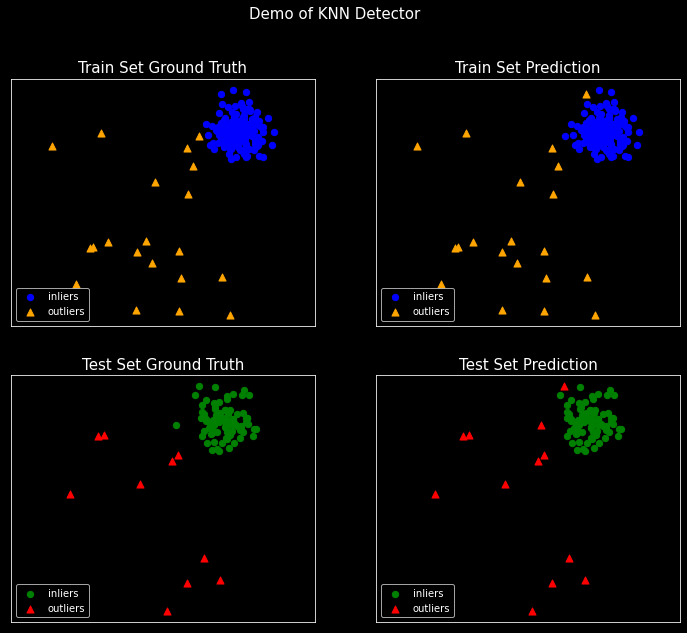

In [141]:
# ▶ visualize the results
visualize(clf_name, X_train, y_train, X_test, y_test, y_train_pred,
          y_test_pred, show_figure=True, save_figure=True)

## Ch02-(3). 🎯 LOF 이상 탐지
___
* 정의
```
# Density-based Methods LOF(Local Outlier Factor) 
# 대부분의 이상탐지 알고리즘은 Global(전역) 관점에서 개별의 관측치가 이상인지 판별함
# 상위의 단점을 극복하기 위해, Local(국소적) 정보를 이용하여 이상인지를 판별함
# LOF는 관측치가 데이터 안에서 얼마나 벗어나 있는가에 대한 정도를 나타냄
# 'K' Hyper parameter를 통해 주변 데이터를 몇 개까지 고려할지를 결정
# LOF < 1 : 밀도가 높은 분포
# LOF = 1 : 이웃 관측치와 비슷한 분포
# LOF > 1 : 밀도가 낮은분포, 크면 클수록 이상치 정도가 큼
```
<img src = "https://drive.google.com/uc?id=1Oa2Han1oF7NILaq26sMTd4nf0bg9QioF">
<img src = "https://drive.google.com/uc?id=1f1ccNCWYhaNa75GnG2Nu3PSkGokpUfmA">


* 장단점
```
  # [good] 굉장히 밀집한 클러스터에서 조금만 떨어져 있어도 이상치로 탐지
  # [good] KNN과 다르게 특별한 라벨링이 없어도 사용할 수 있음 
  # [good] Local Outlier를 탐지할 수 있음
  # [good] 데이터에 대한 가정이 필요 없음
  # [bad] 데이터의 차원수가 증가할 수록 계산량이 많음
  # [bad] 이상치 판단 기준 설정 어려움 (※ 밀집도가 다른 여러 클러스터가 존재한다면 민감하게 반응함)
```
  
* 사용방법
```
# sklearn.neighbors 패키지 활용
# n_neighbors 결정 (※ 이외에 다양한 Hyper parameter 결정)
# 표준화(Min-Max nomalization or z-score standardization)
# 새로운 Data에 대해 지속 수행
```

* 현업사례
```
# 공정(설비) 데이터 이상탐지
# 공정 센서 데이터 실시간 이상탐지
```


### Ch02-(3). ✍ Toy data 실습
___

In [143]:
import numpy as np
import pandas as pd
from sklearn.neighbors import LocalOutlierFactor

# ▶ Toy data 생성
df_train = pd.DataFrame([
        [2, 1, 3],
        [3, 2, 5],
        [3, 4, 7],
        [5, 5, 10],
        [7, 5, 12],
        [2, 5, 7],
        [8, 9, 13],
        [9, 10, 13],
        [6, 5, 12], # ▶ 이상값 추가
        [7, 6, 13], # ▶ 이상값 추가
        [6, 12, 12]
    ], columns=['hour', 'attendance', 'score'])

df_test = pd.DataFrame([
        [9, 2, 13],
        [6, 10, 12],
        [2, 4, 6]
    ], columns=['hour', 'attendance', 'score'])

In [144]:
# ▶ 데이터 확인
df_test

,hour,attendance,score
0,9,2,13
1,6,10,12
2,2,4,6


- 하이퍼 파라미터를 잡기가 정말 힘들다
- 일단 default로 돌려본다
- 왜 알고리즘이 default하게 이상치를 잡아내는지 생각해본다
- 공식문서에서 어느정도의 데이터크기를 사용하는지 등을 읽고 참조한다
- 파라미터변환할 때마다 결과를 계속 기록하면서 개선상황을 추적한다
- LOF의 경우는 데이터셋에 따라 Threshold를 미세하게 조정하면서 볼 수 있다는 점에서 장점이 있다

In [145]:
# ▶ 모델 생성 및 예측
outlier = LocalOutlierFactor(n_neighbors=5, contamination=0.2)
y_predict = outlier.fit_predict(df_train)
df_train['outlier'] = y_predict
df_train

,hour,attendance,score,outlier
0,2,1,3,-1
1,3,2,5,-1
2,3,4,7,1
3,5,5,10,1
4,7,5,12,1
5,2,5,7,1
6,8,9,13,1
7,9,10,13,1
8,6,5,12,1
9,7,6,13,1


In [148]:
# ▶ LOF 값 확인
# ▶ negative_outlier_factor_ : The opposite LOF of the training samples.
# 1보다 큰 값을 이상치로 생각했는데 실제 알고리즘에선 -으로 나온다
outlier.negative_outlier_factor_

array([-1.26622122, -1.17626691, -1.1053571 , -0.98698008, -0.93100953,
       -1.1053571 , -1.08159108, -1.02235872, -0.87139861, -0.97624582,
       -1.16516679])

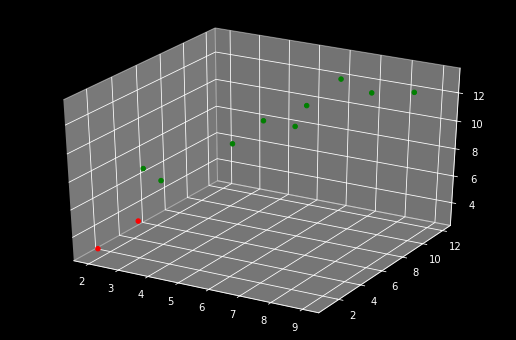

In [151]:
# ▶ 3D plot 및 확인
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection='3d')

df_red = df_train[df_train['outlier']==-1]
df_green = df_train[df_train['outlier']==1]

ax.scatter(df_red['hour'], df_red['attendance'],df_red['score'], color = 'r', alpha = 1);
ax.scatter(df_green['hour'], df_green['attendance'],df_green['score'], color = 'g', alpha = 1);

## Ch03-(1). 🎯 Isoaltion Forest 이상 탐지
___
* 정의
```
# Unsupervised Anomaly Deteciotn 중 하나의 기법
# 여러 개의 의사결정나무(decision tree)를 종합한 앙상블 기반의 이상탐지 기법
# 의사결정나무를 지속적으로 분기시키면서 모든 데이터 관측치의 고립 정도 여부에 따라 이상치를 판별하는 방법
# 비정상 데이터라면 의사결정나무 루트(root)에서 가까운 단계에서 고립
# 정상 데이터라면 루트(root)에서 먼 단계에서 고립
# 특정 관측치가 고립되는 Leaf 노드까지의 거리를 Outlier Score로 정의
# 루트(root) 노드까지의 평균 거리가 짧을 수록 Outlier Score가 높아짐
```
<img src = "https://drive.google.com/uc?id=1tcAaNi2mAcdxj__gM_uzJBN221xMhuAM" width="450" height="200">
<img src = "https://drive.google.com/uc?id=15fCn00JASUkSO0dj7hM1TgpqJGGMKIld" width="400" height="">

* 장단점
```
  # [good] 군집기반 이상탐지 알고리즘에 비해 계산량이 매우 적음 (※ Sampling 사용 Tree 생성)
  # [good] Anomaly Detection 성능 우수 (※ Robust)
  # [good] Train data에 이상치가 포함되지 않아도 잘 동작함 
  # [bad] 분리를 위한 선을 수직과 수평으로만 자르기 때문에 잘못된 scoring이 발생할 수 있음 (※ 대안책 Extended Isolation Forest)
```
  
* 사용방법
```
# from sklearn.ensemble import IsolationForest
# 데이터 현황(분포 및 특성) 파악
# Hyper-paramter 결정
# 학습 및 예측
# threshold 및 scoring 
```

* 현업사례
```
# 로그 데이터 이상탐지
# 품질관리를 위한 이상탐지
```


### Ch03-(1). ✍ Toy data 실습
___

In [33]:
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest

rng = np.random.RandomState(42)
# ▶ Generating training data 
X_train = 0.2 * rng.randn(1000, 2)
X_train = np.r_[X_train + 3, X_train]
X_train = pd.DataFrame(X_train, columns = ['x1', 'x2'])

# ▶ Generating new, 'normal' observation
X_test = 0.2 * rng.randn(200, 2)
X_test = np.r_[X_test + 3, X_test]
X_test = pd.DataFrame(X_test, columns = ['x1', 'x2'])

# ▶ Generating outliers
X_outliers = rng.uniform(low=-1, high=5, size=(50, 2))
X_outliers = pd.DataFrame(X_outliers, columns = ['x1', 'x2'])

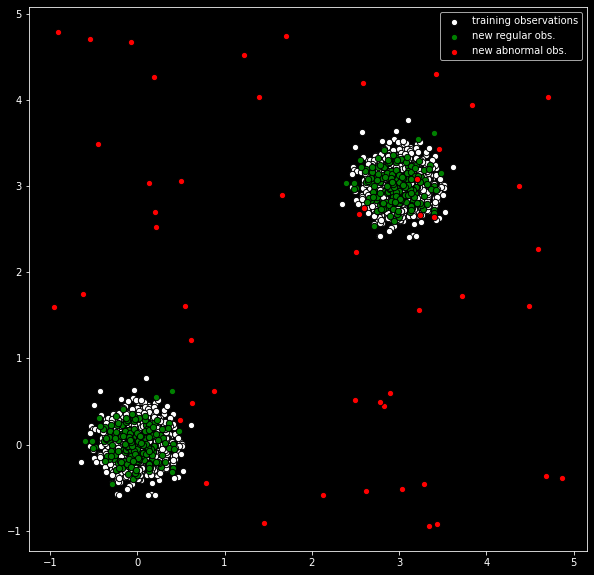

In [34]:
import matplotlib.pyplot as plt
plt.style.use(['dark_background'])
plt.rcParams['figure.figsize'] = [10, 10]

# ▶ Train set
p1 = plt.scatter(X_train.x1, X_train.x2, c='white', s=20*2, edgecolor='k', label='training observations')

# ▶ Test set, 정상 Sample로 구성
p2 = plt.scatter(X_test.x1, X_test.x2, c='green', s=20*2, edgecolor='k', label='new regular obs.')

# ▶ Outlier set
p3 = plt.scatter(X_outliers.x1, X_outliers.x2, c='red', s=20*2, edgecolor='k', label='new abnormal obs.')

plt.legend()
# plt.gcf().set_size_inches(5, 5)

In [35]:
# ▶ Model 학습 및 예측
# - n_estimators : 나무의 개수 (※ default 100)
# - max_samples : 샘플링 데이터 개수 (※ 정수, 실수(0~1), 전체 데이터 개수 or 256 중 작은 수)
# - contamination : 전체 데이터에서 이상치의 비율, 이 비율에 따라 이상치로 판단하기 위한 score의 threshold를 정의
# - max_features : 학습 시 사용할 Feature (※ default 1, 모두 사용)

clf = IsolationForest(max_samples=100, contamination = 0.05, random_state=42)
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)

In [36]:
# ▶ -1 : Outlier / 1 : Normal
y_pred_outliers

array([-1, -1, -1,  1, -1, -1, -1,  1, -1, -1, -1, -1, -1, -1,  1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1])

In [37]:
# ▶ Score, 낮을 수록 Outlier, 음수
clf.decision_function(X_outliers)

array([-0.07397915, -0.10344893, -0.06839828,  0.00754778, -0.02594477,
       -0.10344893, -0.03858639,  0.02753773, -0.06375707, -0.06988794,
       -0.09467105, -0.07814982, -0.08015771, -0.04450317,  0.12127897,
       -0.08251879, -0.0615171 , -0.0839109 , -0.08435337, -0.01324472,
       -0.09467105, -0.08594633, -0.09647411, -0.09101499, -0.0648407 ,
       -0.08185362, -0.0200524 , -0.03235862, -0.06813104, -0.07117076,
       -0.09423924, -0.02588178, -0.05521445, -0.08650631, -0.03681947,
       -0.04963059, -0.09951997, -0.09951997, -0.08342488, -0.03517144,
       -0.06276045, -0.08643544, -0.08145166, -0.05683871, -0.06592612,
       -0.00561074, -0.08398277, -0.03698318, -0.02039574,  0.00107149])

In [38]:
# ▶ Score, 높을 수록 Nomral(Inlier), 양수
clf.decision_function(X_test)[0:5]

array([0.13520326, 0.12503499, 0.04709557, 0.14023926, 0.11374595])

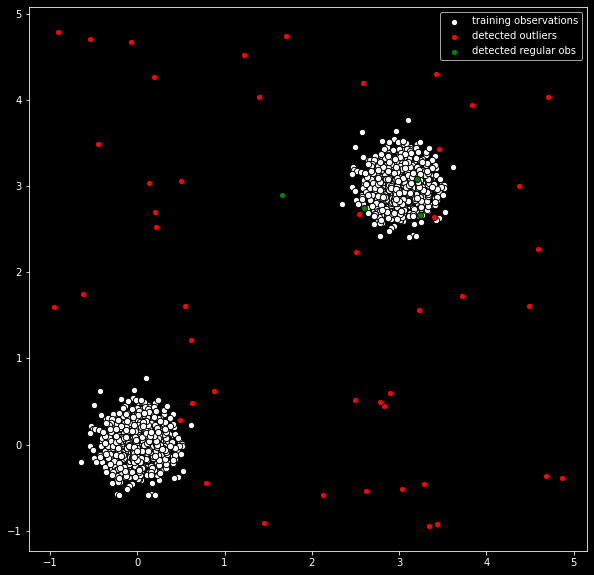

In [39]:
# ▶ Outlier Label 할당
X_outliers = X_outliers.assign(y = y_pred_outliers)

p1 = plt.scatter(X_train.x1, X_train.x2, c='white',
                 s=20*2, edgecolor='k', label="training observations")

p2 = plt.scatter(X_outliers.loc[X_outliers.y == -1, ['x1']], 
                 X_outliers.loc[X_outliers.y == -1, ['x2']], 
                 c='red', s=20*2, edgecolor='k', label="detected outliers")

p3 = plt.scatter(X_outliers.loc[X_outliers.y == 1, ['x1']], 
                 X_outliers.loc[X_outliers.y == 1, ['x2']], 
                 c='green', s=20*2, edgecolor='k', label="detected regular obs")
plt.legend()
plt.gcf().set_size_inches(10, 10)

In [40]:
# ▶ 정상 data set을 얼만큼 정상으로 예측하였는지?
print("테스트 데이터셋에서 정확도:", list(y_pred_test).count(1)/y_pred_test.shape[0])

# ▶ Outlier data set을 얼마나 Outlier로 예측하였는지?
print("이상치 데이터셋에서 정확도:", list(y_pred_outliers).count(-1)/y_pred_outliers.shape[0])

테스트 데이터셋에서 정확도: 0.96
이상치 데이터셋에서 정확도: 0.92


## Ch03-(2). 🎯 One-Class SVM 이상 탐지
___
* 정의
```
# Unsupervised Anomaly Deteciotn 중 하나의 기법
# 데이터를 N차원 좌표축으로 표현하고, 원점과의 거리를 기준으로 초평면(Hyper plane)을 그어 Classification하는 방법
# SVM(Support Vector Machine)은 Binary-Classification에 활용되며 Support Vector 간의 Margine을 기준으로 Hyper Plane을 나눔
# 반면 OCSVM은 원점을 기준으로 정상과 이상에 대한 Hyper Plane을 찾는 방법
# 일반적으로 Linear Support Vector Machine을 이용하지만, 영역의 구분이 복잡해지면 RBF(Radial Basis Functions)와 같은 커널 함수를 사용
# 선형으로 데이터를 분리할 수 없을때 RBF(방사형) 커널 활용
# Loss 함수 : min(Abnormal 데이터들과 Hyper Plane 사이의 거리)
```
<img src = "https://drive.google.com/uc?id=1q1-76h31hhpwXrNMQ3ZyuBWX2xXcxFTF" width="500" height="400">

* 장단점
```
  # [good] 데이터 Label이 존재하지 않아도 사용 가능
  # [good] 저차원이나 고차원의 적은 데이터에서 일반화 능력이 좋음
  # [good] 데이터 특성이 적어도 성능이 좋게 나오는 편, Robust 함
  # [bad] Kernel 기반의 방법론, 데이터가 늘어날 수록 연산량이 크게 증가함
  # [bad] Scaling에 민감함
  # [bad] Hyper parameter 조절을 잘 해야 최적의 모델을 구할 수 있음
```
  
* 사용방법
```
# from sklearn import svm
# Hyper-paramter 결정 (※ Kernel, gamma, nu 등)
# 데이터 현황(분포 및 특성) 파악
# 학습 및 예측
```

* 현업사례
```
# 금융 이상 거래 탐지 
# 온라인 서명 검증 
```

### Ch03-(2). ✍ Toy data 실습
___

In [41]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.font_manager
from sklearn import svm

rng = np.random.RandomState(50)
# ▶ Generate train data
X = 0.3 * rng.randn(100, 2)
X_train = np.r_[X + 2, X - 2]
X_train = pd.DataFrame(X_train, columns = ['x1', 'x2'])

# ▶ Generate some regular novel observations
X = 0.3 * rng.randn(20, 2)
X_test = np.r_[X + 2, X - 2]
X_test = pd.DataFrame(X_test, columns = ['x1', 'x2'])

# ▶ Generate some abnormal novel observations
X_outliers = rng.uniform(low=-4, high=4, size=(20, 2))
X_outliers = pd.DataFrame(X_outliers, columns = ['x1', 'x2'])

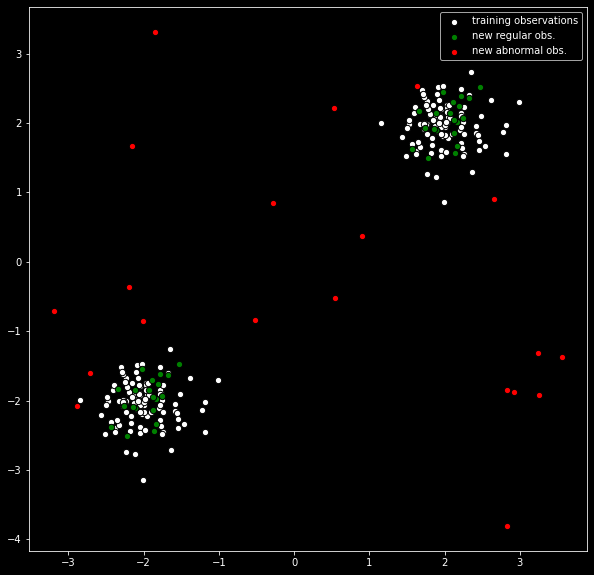

In [42]:
import matplotlib.pyplot as plt
plt.style.use(['dark_background'])

plt.rcParams['figure.figsize'] = [10, 10];
p1 = plt.scatter(X_train.x1, X_train.x2, c='white', s=20*2, edgecolor='k', label='training observations');

# ▶ Test set, 정상 Sample 
p2 = plt.scatter(X_test.x1, X_test.x2, c='green', s=20*2, edgecolor='k', label='new regular obs.');

# ▶ Outlier set
p3 = plt.scatter(X_outliers.x1, X_outliers.x2, c='red', s=20*2, edgecolor='k', label='new abnormal obs.');

plt.legend();
# plt.gcf().set_size_inches(5, 5)

In [43]:
# ▶ 모델 학습 및 평가
# ▶ Kernel : Hyper plane의 종류 (Linear vs rbf)
# ▶ gamma : Support vector와의 거리, 크면 가까이 있는 데이터, 작으면 먼 데이터 참조
# ▶ nu : Hyper plane 밖에 있는(abnormal) data의 비율

clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)

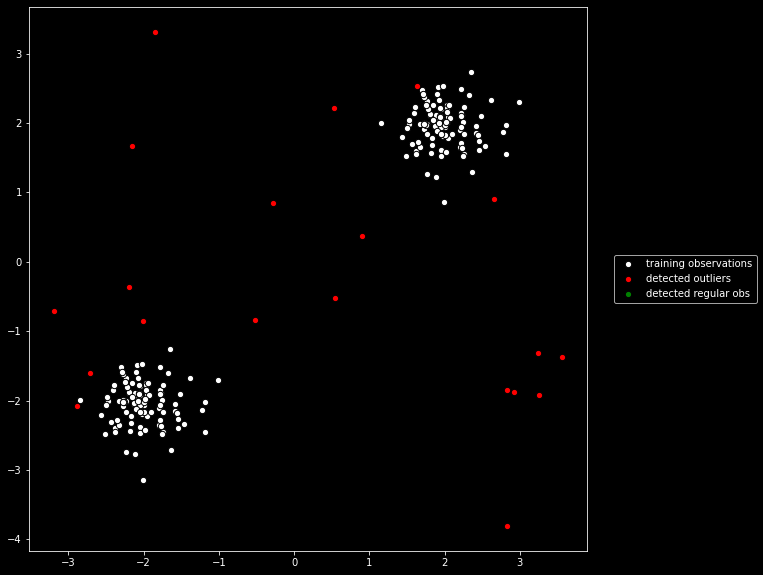

In [44]:
# ▶ Outlier Label 할당
X_outliers = X_outliers.assign(y = y_pred_outliers)

p1 = plt.scatter(X_train.x1, X_train.x2, c='white',
                 s=20*2, edgecolor='k', label="training observations")

p2 = plt.scatter(X_outliers.loc[X_outliers.y == -1, ['x1']], 
                 X_outliers.loc[X_outliers.y == -1, ['x2']], 
                 c='red', s=20*2, edgecolor='k', label="detected outliers")

p3 = plt.scatter(X_outliers.loc[X_outliers.y == 1, ['x1']], 
                 X_outliers.loc[X_outliers.y == 1, ['x2']], 
                 c='green', s=20*2, edgecolor='k', label="detected regular obs")

plt.legend(loc='center left', bbox_to_anchor=(1.04,0.5));
plt.gcf().set_size_inches(10, 10)

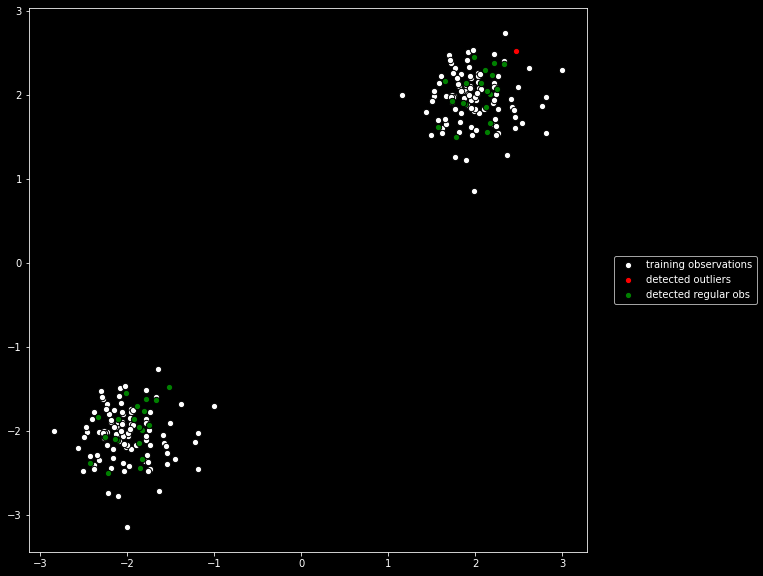

In [45]:
# ▶ Test set 검증
X_test = X_test.assign(y = y_pred_test)

p1 = plt.scatter(X_train.x1, X_train.x2, c='white',
                 s=20*2, edgecolor='k', label="training observations")

p2 = plt.scatter(X_test.loc[X_test.y == -1, ['x1']], 
                 X_test.loc[X_test.y == -1, ['x2']], 
                 c='red', s=20*2, edgecolor='k', label="detected outliers")

p3 = plt.scatter(X_test.loc[X_test.y == 1, ['x1']], 
                 X_test.loc[X_test.y == 1, ['x2']], 
                 c='green', s=20*2, edgecolor='k', label="detected regular obs")

plt.legend(loc='center left', bbox_to_anchor=(1.04,0.5));
plt.gcf().set_size_inches(10, 10)

In [46]:
# ▶ 정상 data set을 얼만큼 정상으로 예측하였는지?
print("테스트 데이터셋에서 정확도:", list(y_pred_test).count(1)/y_pred_test.shape[0])

# ▶ Outlier data set을 얼마나 Outlier로 예측하였는지?
print("이상치 데이터셋에서 정확도:", list(y_pred_outliers).count(-1)/y_pred_outliers.shape[0])

테스트 데이터셋에서 정확도: 0.975
이상치 데이터셋에서 정확도: 1.0


## Ch03-(3). 🎯 Autoencoder
___
* 정의
```
# 비지도학습(Unsupervised Learning) 이상탐지 영역에서 활용됨
# 오터인코더(Auto Encoder)란 입력을 출력으로 복사하는 신경망
# 데이터를 압축하는 부분을 인코더(Encoder)
# 데이터를 복원하는 부분을 디코더(Decoder)
# 고차원 데이터를 잘 표현해주는 잠재 벡터(latent vector)을 자동으로 추출해주는 모델
# 고차원 데이터의 가장 중요한 특징을 학습하는 것
# 정상 데이터의 특징을 학습하고, 비정상 데이터를 Input하면 Loss(MSE)가 커짐
```
<img src = "https://drive.google.com/uc?id=1loR-rn4TixzAQQaepi23LDRPDS8S-0t3">
<img src = "https://drive.google.com/uc?id=1NOu1PJd1meaqNDWAL19p2f-CAg6R9k4n">
* 장단점
```
  # [good] 데이터 Label이 존재하지 않아도 사용 가능
  # [good] 고차원에 데이터의 특징을 추출할 수 있음
  # [good] Auto encoder를 기반으로 다양한 알고리즘 존재 
  # [bad] Hyper parameter (※ hidden layer) 설정이 어려움 
  # [bad] Loss(MSE)에 대한 thresgold 설정이 어려움 
```
  
* 사용방법
```
# from pyod.models.auto_encoder import AutoEncoder
# 정상 Data 확보 
# Hyper-paramter 결정 (※ hidden layer)
# 학습 및 예측
# threshold 및 scoring 
```

* 현업사례
```
# 시계열 센서 데이터 이상 탐지
```


### Ch03-(3). ✍ Toy data 실습
___

In [47]:
# ▶ pyod 패키지 설치
!pip install pyod

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [48]:
# ▶ Toy data 생성
from pyod.models.auto_encoder import AutoEncoder
from pyod.utils.data import generate_data
from pyod.utils.data import evaluate_print

contamination = 0.1  # ▶ percentage of outliers
n_train = 20000      # ▶ number of training points
n_test = 2000        # ▶ number of testing points
n_features = 300     # ▶ number of features

X_train, X_test, y_train, y_test = \
    generate_data(n_train=n_train,
                  n_test=n_test,
                  n_features=n_features,
                  contamination=contamination,
                  random_state=42)

In [49]:
# X_train[1]
# y_train[1]
# X_train[-1]
# y_train[-1]

In [50]:
# ▶ 모델 생성/학습 및 Hyper paramter 선정
clf_name = 'AutoEncoder'
clf = AutoEncoder(hidden_neurons =[300, 100, 100, 300], epochs=10, contamination=contamination)
clf.fit(X_train)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 300)               90300     
                                                                 
 dropout (Dropout)           (None, 300)               0         
                                                                 
 dense_1 (Dense)             (None, 300)               90300     
                                                                 
 dropout_1 (Dropout)         (None, 300)               0         
                                                                 
 dense_2 (Dense)             (None, 300)               90300     
                                                                 
 dropout_2 (Dropout)         (None, 300)               0         
                                                                 
 dense_3 (Dense)             (None, 100)               3

AutoEncoder(batch_size=32, contamination=0.1, dropout_rate=0.2, epochs=10,
      hidden_activation='relu', hidden_neurons=[300, 100, 100, 300],
      l2_regularizer=0.1,
      loss=<function mean_squared_error at 0x7f615f9e4b80>,
      optimizer='adam', output_activation='sigmoid', preprocessing=True,
      random_state=None, validation_size=0.1, verbose=1)

In [51]:
y_train_pred = clf.labels_             # ▶ binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # ▶ raw outlier scores

# ▶ get the prediction on the test data
y_test_pred = clf.predict(X_test)              # ▶ outlier labels (0 or 1)
y_test_scores = clf.decision_function(X_test)  # ▶ outlier scores

63/63 [==============================] - 0s 3ms/step


In [52]:
# ▶ score가 높을 수록 Outlier에 가까움
y_train_pred[0:5], y_train_scores[0:5]

(array([0, 0, 0, 0, 0]),
 array([7.60971419, 8.28965693, 7.98080129, 8.19790157, 7.2238141 ]))

In [53]:
y_test_pred[1950:2000], y_test_scores[1950:2000]

(array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1]),
 array([50.79145908, 50.13003009, 50.52623423, 46.79573461, 50.69044085,
        48.90139248, 48.41739148, 47.7352326 , 51.25090769, 49.84675697,
        49.64966672, 47.76490169, 49.49891787, 49.06098264, 51.13531548,
        50.23404399, 51.50401244, 48.45978042, 50.78039905, 50.84201392,
        51.19974399, 50.03768611, 48.23246965, 48.87683316, 50.99513865,
        49.80783311, 48.55319038, 48.5672988 , 48.61679375, 48.73707474,
        48.4923737 , 51.07325157, 49.03624992, 49.19424531, 49.30337231,
        49.26017738, 50.81335918, 46.92287609, 50.73979088, 49.66624694,
        49.67382058, 50.23133389, 45.11813744, 50.61582647, 47.55189608,
        50.92975557, 48.6479941 , 49.51357147, 50.20662901, 47.47835331]))

In [54]:
# ▶ Outlier 예측 데이터 수
import pandas as pd
pd.Series(y_train_pred).value_counts()

0    18000
1     2000
dtype: int64

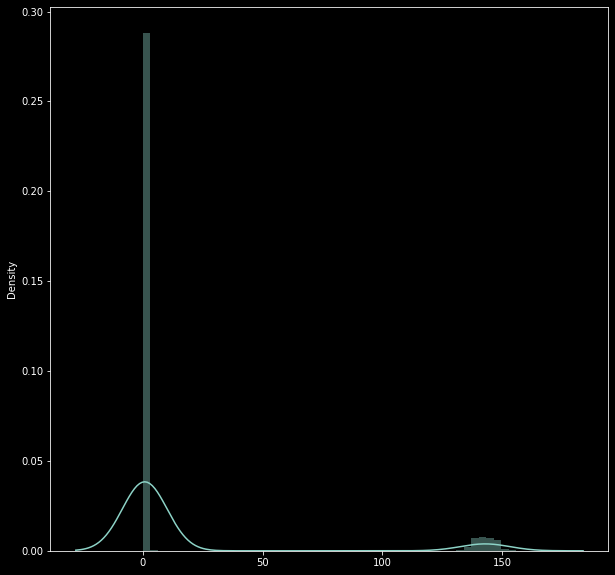

In [55]:
# ▶ threshold 결정을 위한 modified Z점수 표준화 (※ 이상치에 Robust한 표준화 방법)
import seaborn as sns
import numpy as np

def mod_z(col) :
    med_col = col.median()
    med_abs_dev = (np.abs(col - med_col)).median()
    mod_z = 0.7413 * ((col - med_col) / med_abs_dev)
    return np.abs(mod_z)

pd_s = pd.Series(y_test_scores);
mod_z = mod_z(pd_s);
sns.distplot(mod_z);

In [56]:
# ▶ 성능평가
print("\nOn Training Data:")
evaluate_print(clf_name, y_train, y_train_scores)
print("\nOn Test Data:")
evaluate_print(clf_name, y_test, y_test_scores)


On Training Data:
AutoEncoder ROC:1.0, precision @ rank n:1.0

On Test Data:
AutoEncoder ROC:1.0, precision @ rank n:1.0


## Ch04-(1). 🎯 PCA 이상 탐지
___
* 정의
```
# 여러 변수 간에 존재하는 상관관계를 이용하여 이를 대표한 주성분을 추출해 차원을 축소하는 기법
# 기존 데이터의 유실을 최소하 하기 위해 데이터의 분산을 최대화 할 수 있는 초평면(Hyper plane)을 찾고 데이터를 투영함
# Auto encoder와 작동원리가 비슷함
# 다중공선성을 제거하기 위해 각 벡터의 축이 직각이 되도록 투영 시킴
# 원본 데이터의 Feature 개수에 비해 매우 적은 주성분으로 원본 데이터의 총 변동성을 대부분 설명할 수 있는 분석법
```
<img src = "https://drive.google.com/uc?id=16dNJTSMUiFmk4wQtJ7hP3HmL0wUy1vgP">

* 장단점
```
  # [good] 고차원에 데이터를 저차원에 주성분으로 표현할 수 있음
  # [good] 선택한 변수들의 해석이 용이함
  # [bad] 변수간 상관관계 고려가 어려움 
  # [bad] 추출된 변수의 해석이 어려움 (※ 주성분, PC1/PC2 ...)
```
  
* 사용방법
```
# from sklearn.decomposition import PCA
# 데이터 정규화 필수
# 학습 데이터셋에서 분산이 최대인 축(axis)을 탐색
# 이렇게 찾은 첫번째 축과 직교(orthogonal)하면서 분산이 최대인 두 번째 축을 탐색
# 첫 번째 축과 두 번째 축에 직교하고 분산을 최대한 보존하는 세 번째 축을 탐색
# 1~3과 같은 방법으로 데이터셋의 차원(특성 수)만큼의 축을 탐색
```

* 현업사례
```
# 다양한 검사 공정에서 이상 제품 탐지
# 데이터 EDA를 통한 클러스터링
```


### Ch04-(1). ✍ Toy data 실습
___

In [57]:
# ▶ iris data set 로드 (Toy data)
from sklearn.datasets import load_iris
iris = load_iris()
df = pd.DataFrame(data= np.c_[iris.data, iris.target] , 
                  columns= ['sepal length', 'sepal width', 'petal length', 'petal width', 'target'])

In [58]:
# ▶ Data 확인 
df.head()

,sepal length,sepal width,petal length,petal width,target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


In [59]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# ▶ Create scaler: scaler
scaler = StandardScaler()

# ▶ Create a PCA instance: pca
pca = PCA()

# ▶ Create pipeline: pipeline
pipeline = make_pipeline(scaler,pca)

pipeline.fit(df.drop(['target'], axis=1))

Pipeline(steps=[('standardscaler', StandardScaler()), ('pca', PCA())])

In [60]:
# ▶ pca.n_components_(차원 축소 주성분 개수)
features = range(pca.n_components_)
feature_df=pd.DataFrame(data=features,columns=['pc_feature'])

# ▶ pca.explained_variance_ratio_(설명력)
variance_df=pd.DataFrame(data=pca.explained_variance_ratio_,columns=['variance'])
pc_feature_df=pd.concat([feature_df,variance_df],axis=1)
pc_feature_df

# ▶ PC0, PC1으로도 전체 분산에 95% 이상 설명 가능

,pc_feature,variance
0,0,0.729624
1,1,0.228508
2,2,0.036689
3,3,0.005179


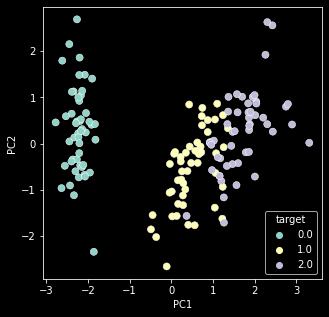

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use(['dark_background'])

x=df.drop(['target'], axis=1).reset_index(drop=True)
y=df['target'].reset_index(drop=True).astype(str)

# ▶ 정규화
X_ = StandardScaler().fit_transform(x)

# ▶ 2개의 주성분으로 차원 축소
pca = PCA(n_components=2)
pc = pca.fit_transform(X_)


pc_df=pd.DataFrame(pc,columns=['PC1','PC2']).reset_index(drop=True)
pc_df=pd.concat([pc_df,y],axis=1)

plt.rcParams['figure.figsize'] = [5, 5]
sns.scatterplot(data=pc_df,x='PC1',y='PC2',hue=y, legend='brief', s=50, linewidth=0.5);

# ▶ 각 클러스터 중심에서 멀리 떨어진 Data 일 수록 이상치

## Ch04-(1). 🎯 t-SNE 이상 탐지
___
* 정의
```
# PCA는 선형 분석 방식으로 값을 투영하기 때문에 차원이 감소되면서 군집화 되어 있는 데이터들이 밀집되어 구별하기 어려운 단점
# 상위의 단점을 보완하기 위한 차원 감소 방법 t-SNE
# t-분포를 사용하여 데이터 유사도를 계산하므로, 꼬리가 두꺼운(분산이 큰) t-분포에서는 유사도(similarity)가 낮은 데이터일 수록  
더 멀리 떨어뜨리는 효과 발생
# 유사도(similarity)가 비슷한 데이터끼리 묶어줌
# t-분포를 이용하여 기준점과 상대점과의 거리를 기준으로 t-분포의 확률분포를 유사도(similarity)로 사용하여 표현
# 주로 시각화 Tool로 사용
```
<img src = "https://drive.google.com/uc?id=1fiwBO7-GG0SuHmkrXYS36WXodGhWfRVN" width="300" height="270">
<img src = "https://drive.google.com/uc?id=1xuiR2Yhc1YgXNHdOFpSU5GsxJqdCEwjp" width="500" height="270">


* 장단점
```
  # [good] PCA 대비 조금 더 고차원에 데이터를 저차원에 데이터로 클러스터링 하는데 유리 (※ 군집이 중복되지 않는 효과)
  # [good] 사용하기 쉬움
  # [good] 비선형 관계의 데이터를 군집화 할 수 있음
  # [bad] 데이터의 개수가 많을 수록 연산량이 증가함
  # [bad] 매번 돌릴 때마다 다른 시각화 결과가 도출됨
```
  
* 사용방법
```
# from sklearn.manifold import TSNE
# 데이터 정규화 필수
# Hyper parameter 선정
# 시각화 및 클러스터링
```

* 현업사례
```
# 다양한 검사 공정에서 이상 제품 탐지
# 데이터 EDA를 통한 클러스터링
```


### Ch04-(1). ✍ Toy data 실습
___

In [62]:
from sklearn.datasets import load_iris
import pandas as pd
import numpy as np

# ▶ 데이터셋 로드
iris = load_iris()
df = pd.DataFrame(data= np.c_[iris.data, iris.target] , 
                  columns= ['sepal length', 'sepal width', 'petal length', 'petal width', 'target'])
df.head()

,sepal length,sepal width,petal length,petal width,target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


In [63]:
from sklearn.manifold import TSNE

# ▶ class target 정보 제외
train_df = df[['sepal length', 'sepal width', 'petal length', 'petal width']]

# ▶ 2차원 t-SNE 임베딩
# - n_components : 차원 수
# - perplexity : 주변 이웃 데이터 참조 개수
# - learning_rate : 학습률, 크면 너무 붙어있게 되고 작으면 너무 멀어짐(특징X)
# - n_iter : 최적화 반복 횟수
tsne_np = TSNE(n_components = 2).fit_transform(train_df)

# ▶ numpy array -> DataFrame 변환
tsne_df = pd.DataFrame(tsne_np, columns = ['component 0', 'component 1'])
tsne_df

,component 0,component 1
0,16.976980,20.877596
1,17.489737,23.316605
2,16.453516,23.579700
3,16.656368,23.845129
4,17.354496,20.829567
...,...,...
145,-3.540664,-14.746209
146,-5.424568,-12.162124
147,-4.018494,-13.998941
148,-2.680717,-15.109284


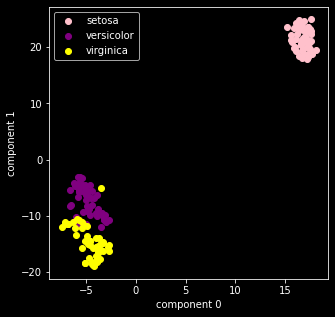

In [64]:
import matplotlib.pyplot as plt

# ▶ class target 정보 불러오기 
tsne_df['target'] = df['target']

# ▶ target 별 분리
tsne_df_0 = tsne_df[tsne_df['target'] == 0]
tsne_df_1 = tsne_df[tsne_df['target'] == 1]
tsne_df_2 = tsne_df[tsne_df['target'] == 2]

# ▶ target 별 시각화
plt.scatter(tsne_df_0['component 0'], tsne_df_0['component 1'], color = 'pink', label = 'setosa')
plt.scatter(tsne_df_1['component 0'], tsne_df_1['component 1'], color = 'purple', label = 'versicolor')
plt.scatter(tsne_df_2['component 0'], tsne_df_2['component 1'], color = 'yellow', label = 'virginica')

plt.xlabel('component 0')
plt.ylabel('component 1')
plt.legend()
plt.show()

In [65]:
# ▶ 3차원 t-SNE 임베딩
tsne_np = TSNE(n_components = 3).fit_transform(train_df)

# ▶ numpy array -> DataFrame 변환
tsne_df = pd.DataFrame(tsne_np, columns = ['component 0', 'component 1', 'component 2'])
tsne_df

,component 0,component 1,component 2
0,61.295448,-23.889254,-114.239883
1,87.828133,-25.085394,-53.979034
2,-56.162148,-153.529800,130.849854
3,111.319023,1.541727,-92.329163
4,15.022561,14.483906,-84.248474
...,...,...,...
145,10.105426,-78.870674,63.958752
146,-78.416756,-28.673100,17.561777
147,35.745991,-102.545975,91.912895
148,-23.946703,-154.780380,62.878895


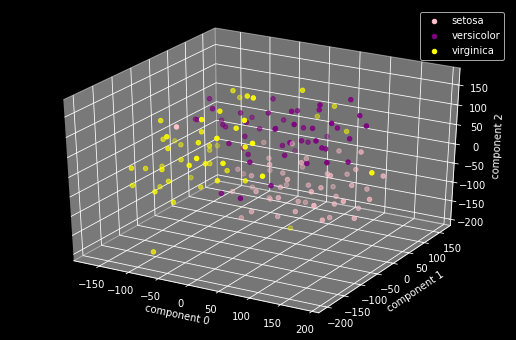

In [66]:
from mpl_toolkits.mplot3d import Axes3D

# ▶ 3차원 그래프 세팅
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection='3d')

# ▶ class target 정보 불러오기 
tsne_df['target'] = df['target']

# ▶ target 별 분리
tsne_df_0 = tsne_df[tsne_df['target'] == 0]
tsne_df_1 = tsne_df[tsne_df['target'] == 1]
tsne_df_2 = tsne_df[tsne_df['target'] == 2]

#  ▶ target 별 시각화
ax.scatter(tsne_df_0['component 0'], tsne_df_0['component 1'], tsne_df_0['component 2'], color = 'pink', label = 'setosa')
ax.scatter(tsne_df_1['component 0'], tsne_df_1['component 1'], tsne_df_1['component 2'], color = 'purple', label = 'versicolor')
ax.scatter(tsne_df_2['component 0'], tsne_df_2['component 1'], tsne_df_2['component 2'], color = 'yellow', label = 'virginica')

ax.set_xlabel('component 0')
ax.set_ylabel('component 1')
ax.set_zlabel('component 2')
ax.legend()
plt.show()

## Ch05-(1). 🎯 S-H-ESD
___
* 정의
```
# Seasonal Hybrid ESD(S-H-ESD), Contextual Anomaly(시계열 동적 이상탐지)
# SNS 서비스(트위터)는 기존의 통계적 방법론들을 조합하여 시계열의 이상값을 탐지하는 방법을 제안
# 기존의 평균, 표준편차를 이용하는 방식은 Outlier를 포괄하여 계산하므로 이상값에 취약
# 평균과 표준편차가 seasonality, trend 등에 의해 변환되어 Outlier를 놓치게 되는 경우 발생
 🔻 핵심 개념 🔻
(1) Median Absolute Deviation(MAD): 관측값에서 중앙값을 뺀 값들의 중앙 값, 이상치에 덜 영향을 받는 robust한 분산 측정법
(2) ESD test(Grubb's test): 단일 이상치를 테스트 하는 통계적 방법, 평균에서 얼마나 멀어져있는지를 데이터의 분산과 대비하여 탐색
(3) Generalized ESD: ESD는 하나의 이상치만 발견, 여러개의 Outlier를 탐색, 계절성 고려 X
(4) STL: 시계열 데이터에서 계절성, 추세, 잔차 세가지 패턴요소로 분해하는 기법, 이상탐지에 적합한 residual만 고려
```
<img src = "https://drive.google.com/uc?id=16DJ_NbGq5vJNjj90ZAiR__t2rqthTnfb">
<img src = "https://drive.google.com/uc?id=181agHYMlTGbipqOIYa08iAZ908j-RTVL">



* 장단점
```
  # [good] 노이즈의 증가 (More noise)
  # [good] 급작스런 상승, 급등점 (Sudden grow; spike)
  # [good] 하강(Break down)
  # [good] 보이지 않던 희귀 값 (Activity when usually none)
  # [bad] 점진적 증가 신호(seasonal grow)
  # [bad] 평면적 신호 (Flat signal)
  # [bad] 점진적 증가하는 신호에서의 음의방향 이상치 (Negative seasonal anomaly)
```
  
* 사용방법
```
# !pip install pyculiarity
# from pyculiarity import detect_ts
# 시간 데이터 타입 변경
# 시각화 및 클러스터링
```

* 현업사례
```
# SNS 이상 탐지
```

### Ch05-(1). ✍ Toy data 실습
___

In [67]:
# ▶ package 설치
!pip install pyculiarity

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.0/156.0 KB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyculiarity: filename=pyculiarity-0.0.7-py32-none-any.whl size=24797 sha256=2281dbeac8df89e1c5324474bd41c9b721338bb548443fbe83ed700434d193cb
  Stored in directory: /root/.cache/pip/wheels/aa/90/d1/a074a0abc8689154b26b5d16249855293602afd0e8617c3cb6
Successfully built pyculiarity


In [68]:
# ▶ Toy data 생성
# ▶ Outlier data 삽입 (1000, 1200, 1300)
import pandas as pd
co2 = [315.58,316.39,316.79,317.82,318.39,318.22,316.68,315.01,314.02,313.55,315.02,315.75,316.52,317.10,317.79,319.22,320.08,319.70,318.27,315.99,314.24,314.05,315.05,316.23,316.92,317.76,318.54,319.49,320.64,319.85,318.70,316.96,315.17,315.47,316.19,317.17,318.12,318.72,360, 364,319.79,320.68,321.28,320.89,319.79,317.56,316.46,315.59,316.85,317.87,318.87,319.25,320.13,321.49,322.34,321.62,319.85,317.87,316.36,316.24,317.13,318.46,319.57,320.23,320.89,321.54,322.20,321.90,320.42,318.60,316.73,317.15,317.94,318.91,319.73,320.78,321.23,322.49,322.59,322.35,321.61,319.24,318.23,317.76,319.36,319.50,320.35,321.40,322.22,323.45,323.80,323.50,322.16,320.09,318.26,317.66,319.47,320.70,322.06,322.23,322.78,324.10,324.63,323.79,322.34,320.73,319.00,318.99,320.41,321.68,322.30,322.89,323.59,324.65,325.30,325.15,323.88,321.80,319.99,319.86,320.88,322.36,323.59,324.23,325.34,326.33,327.03,326.24,325.39,323.16,321.87,321.31,322.34,323.74,324.61,325.58,326.55,327.81,327.82,327.53,326.29,324.66,323.12,323.09,324.01,325.10,326.12,326.62,327.16,327.94,329.15,328.79,327.53,325.65,323.60,323.78,325.13,326.26,326.93,327.84,327.96,329.93,330.25,329.24,328.13,326.42,324.97,325.29,326.56,327.73,328.73,329.70,330.46,331.70,332.66,332.22,331.02,329.39,327.58,327.27,328.30,328.81,329.44,330.89,331.62,332.85,333.29,332.44,331.35,329.58,327.58,327.55,328.56,329.73,330.45,330.98,331.63,332.88,333.63,333.53,331.90,330.08,328.59,328.31,329.44,330.64,331.62,332.45,333.36,334.46,334.84,334.29,333.04,330.88,329.23,328.83,330.18,331.50,332.80,333.22,334.54,335.82,336.45,335.97,334.65,332.40,331.28,330.73,332.05,333.54,334.65,335.06,336.32,337.39,337.66,337.56,336.24,334.39,332.43,332.22,333.61,334.78,335.88,336.43,337.61,338.53,339.06,338.92,337.39,335.72,333.64,333.65,335.07,336.53,337.82,338.19,339.89,340.56,341.22,340.92,339.26,337.27,335.66,335.54,336.71,337.79,338.79,340.06,340.93,342.02,342.65,341.80,340.01,337.94,336.17,336.28,337.76,339.05,340.18,341.04,342.16,343.01,343.64,342.91,341.72,339.52,337.75,337.68,339.14,340.37,341.32,342.45,343.05,344.91,345.77,345.30,343.98,342.41,339.89,340.03,341.19,342.87,343.74,344.55,345.28,347.00,347.37,346.74,345.36,343.19,340.97,341.20,342.76,343.96,344.82,345.82,347.24,348.09,348.66,347.90,346.27,344.21,342.88,342.58,343.99,345.31,345.98,346.72,347.63,349.24,349.83,349.10,347.52,345.43,344.48,343.89,345.29,346.54,347.66,348.07,349.12,350.55,351.34,350.80,349.10,347.54,346.20,346.20,347.44,348.67,
349, 350, 351]
co2 = pd.Series(co2, index=pd.date_range("1-1-2022", periods=len(co2), freq="M"), name="CO2")
co2.head()

2022-01-31    315.58
2022-02-28    316.39
2022-03-31    316.79
2022-04-30    317.82
2022-05-31    318.39
Freq: M, Name: CO2, dtype: float64

In [69]:
# ▶ date를 숫자형태(int64)로 변환
import numpy as np
co2 = pd.DataFrame(co2).reset_index()
co2.columns = ['Time', 'CO2']
co2['Time'] = np.int64(co2['Time'])
co2.head()

,Time,CO2
0,1643587200000000000,315.58
1,1646006400000000000,316.39
2,1648684800000000000,316.79
3,1651276800000000000,317.82
4,1653955200000000000,318.39


In [70]:
from pyculiarity import detect_ts
from pyculiarity.date_utils import date_format
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ▶ anomaly detection을 위한 plot 함수
def plot_ts_anoms(inDF, savepath):
    fig = plt.figure(figsize = (22,5))
    plt.plot(inDF.index, inDF['value'], alpha=0.4, label ='value')
    plt.plot(inDF.index, inDF['anoms'],  color='steelblue', alpha=1, marker='o', markersize='7',
                markeredgewidth = 1, markerfacecolor='None', markeredgecolor='red',label='anomalies')
    if 'expected_value' in inDF.columns:
        plt.plot(inDF.index, inDF['expected_value'], color = 'c', marker = '^', markersize = '7',
                 markeredgewidth = 1, markerfacecolor='None', markeredgecolor='c',label='expected_value')

    plt.legend(); plt.xlabel('time');plt.ylabel('value')

In [71]:
# ▶ max_anoms: Maximum number of anomalies that S-H-ESD will detect as a percentage of the
# ▶ 참조 : https://github.com/zrnsm/pyculiarity/blob/master/pyculiarity/detect_ts.py
results = detect_ts(co2, max_anoms=0.10, direction='both')

In [72]:
# ▶ """ Plotting """
# ▶ reformat the index and columns
timeS_DF = co2.set_index('timestamp')

anomsDF = results['anoms']
anomsDF.drop(['timestamp'], axis = 1, inplace = True)
anomsDF['is_anom'] = True
# anomsDF.columns = ['anom_value','is_anom']

merged_DF = pd.merge(left = timeS_DF, right= anomsDF, left_index=True, right_index=True, how = 'left')
# merged_DF.drop('anom_value',axis = 1,inplace=True)

print('>>> the number of anomaly: ', len(results['anoms']))
print(results['anoms'].head())

>>> the number of anomaly:  0
Empty DataFrame
Columns: [anoms, is_anom]
Index: []


In [73]:
merged_DF.head()

,value,anoms,is_anom
timestamp,,,
1643587200000000000,315.58,NaN,NaN
1646006400000000000,316.39,NaN,NaN
1648684800000000000,316.79,NaN,NaN
1651276800000000000,317.82,NaN,NaN
1653955200000000000,318.39,NaN,NaN


In [74]:
# ▶ 시간 형태 변경
merged_DF.index = pd.to_datetime(merged_DF.index)

In [75]:
merged_DF

,value,anoms,is_anom
timestamp,,,
2022-01-31,315.58,NaN,NaN
2022-02-28,316.39,NaN,NaN
2022-03-31,316.79,NaN,NaN
2022-04-30,317.82,NaN,NaN
2022-05-31,318.39,NaN,NaN
...,...,...,...
2051-01-31,347.44,NaN,NaN
2051-02-28,348.67,NaN,NaN
2051-03-31,349.00,NaN,NaN


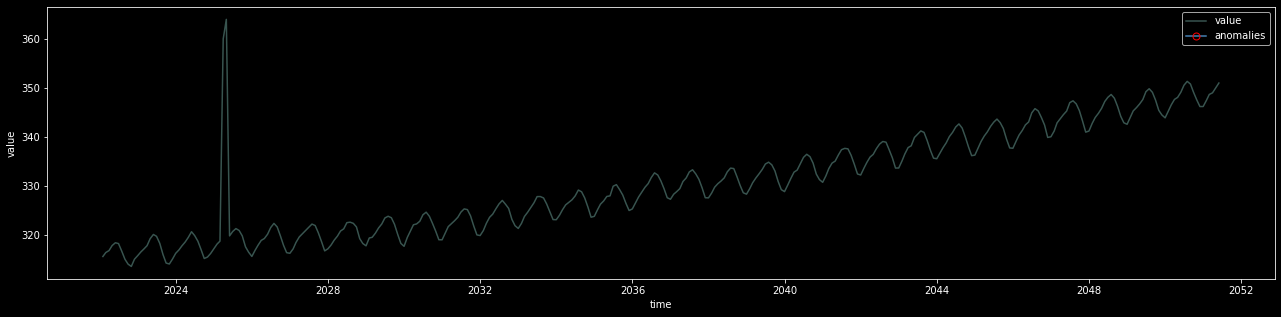

In [76]:
# ▶ plot 및 outlier marking
plt.style.use(['dark_background'])
plot_ts_anoms(merged_DF, 'a')

## Ch05-(2). 🎯 RRCF(Robust Random Cut Forest)
___
* 정의
```
# RRCF(Robust Random Cut Forest)은 트리 기반 이상 감지 모델
# Isolation Forest와 작동 방식은 유사하나, 작은 차이가 엄청난 기여를 함
# Feature p 를 선택할 때 uniform random하게 뽑는 대신, 각 feature가 갖는 값의 범위에 따라 확률을 다르게 부여하여 선택
# 시간에 따라 분포가 점점 달라지는 데이터에 대응하여 트리를 만들 수 있게 됨 (※ streaming data)
# 새로운 데이터 들어올 시, 재학습이 아닌 node 추가/제거 알고리즘을 통해 모델 업데이트
# 평균 분기 횟수 대신, Collusive displacement (CoDisp)라는 새로운 이상 스코어를 사용
# 이상 데이터를 삭제 했을 때, 남은 데이터에서 발생하는 depth 변화 개념 활용 (※ 모델의 복잡성 변화)
# CoDisp 값이 클 수록 이상 데이터로 간주
```
<img src = "https://drive.google.com/uc?id=1wt1y9osr1XQZcd_44WR5-CNo_eJyWB0f" width="600" height="">
<img src = "https://drive.google.com/uc?id=1HRptCVo2GG8lyd-bjjooNyBkt1dMXTTo" width="600" height="">

* 장단점
```
  # [good] 분포가 변화하는 Streaming data에 유리함
  # [good] Batch 및 Streaming data 모두 활용 가능
  # [good] Subsampling을 통한 연산량 감소
  # [good] 보이지 않던 희귀 값 (Activity when usually none)
  # [bad] 분리를 위한 선을 수직과 수평으로만 자르기 때문에 잘못된 scoring이 발생할 수 있음
```
  
* 사용방법
```
# !pip install rrcf
# import rrcf
# ① batch detection 및 ② streaming detection 결정
# CoDisp 활용 scoring 및 이상 탐지
```

* 현업사례
```
# 장비 장애 이력 활용 사전 이상 탐지
```

### Ch05-(2). ✍ Toy data 실습
___

In [77]:
# ▶ rrcf 설치
!pip install rrcf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for rrcf: filename=rrcf-0.4.3-py3-none-any.whl size=9810 sha256=43cdf4ba905d5fa1e74860a570c4af84e9ad8162cc3dc735c963c514a048bfeb
  Stored in directory: /root/.cache/pip/wheels/38/d5/8c/e5d10c99f3cd7b02453fdb4323dabf1d319203f7f1f2281a4a
Successfully built rrcf


In [78]:
# ▶ Set Data parameters
np.random.seed(0)
n = 2010
d = 3

# ▶ Hyper parameters
num_trees = 100
tree_size = 256

# ▶ Generate data
X = np.zeros((n, d))
X[:1000,0] = 5
X[1000:2000,0] = -5
X += 0.01*np.random.randn(*X.shape)
size=(n // tree_size, tree_size)

In [79]:
# ▶ (1) Batch Detection

import numpy as np
import pandas as pd
import rrcf

# ▶ Set parameters
np.random.seed(0)
n = 2010
d = 3
num_trees = 100
tree_size = 256

# ▶ Generate data
X = np.zeros((n, d))
X[:1000,0] = 5
X[1000:2000,0] = -5
X += 0.01*np.random.randn(*X.shape)

# ▶ Construct forest
forest = []
while len(forest) < num_trees:
    # ▶ Select random subsets of points uniformly from point set
    ixs = np.random.choice(n, size=(n // tree_size, tree_size),
                           replace=False)
    # ▶ Add sampled trees to forest
    trees = [rrcf.RCTree(X[ix], index_labels=ix) for ix in ixs]
    forest.extend(trees)

# ▶ Compute average CoDisp
avg_codisp = pd.Series(0.0, index=np.arange(n))
index = np.zeros(n)
for tree in forest:
    codisp = pd.Series({leaf : tree.codisp(leaf) for leaf in tree.leaves})
    avg_codisp[codisp.index] += codisp
    np.add.at(index, codisp.index.values, 1)
avg_codisp /= index

In [80]:
len(avg_codisp)

2010

In [81]:
avg_codisp[0:5]

0     9.421925
1    17.504236
2     3.578805
3     5.145816
4     3.527215
dtype: float64

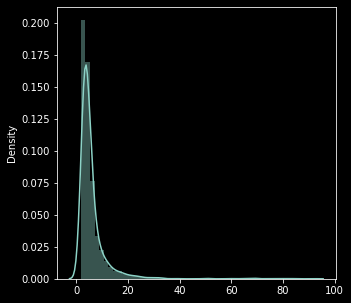

In [82]:
sns.distplot(avg_codisp);

In [83]:
threshold = avg_codisp.nlargest(n=10).min()
threshold

59.57142857142857

Text(0.5, 0.92, 'CoDisp above 99.5th percentile')

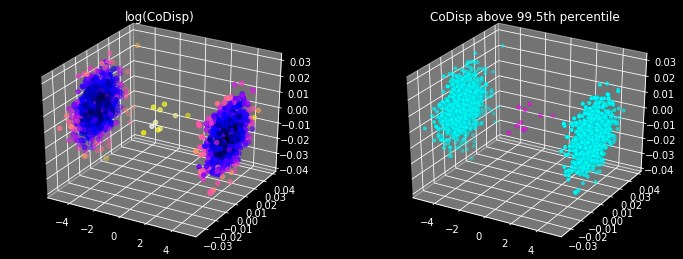

In [84]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import colors

threshold = avg_codisp.nlargest(n=10).min()

fig = plt.figure(figsize=(12,4.5))
ax = fig.add_subplot(121, projection='3d')
sc = ax.scatter(X[:,0], X[:,1], X[:,2],
                c=np.log(avg_codisp.sort_index().values),
                cmap='gnuplot2')
plt.title('log(CoDisp)')
ax = fig.add_subplot(122, projection='3d')
sc = ax.scatter(X[:,0], X[:,1], X[:,2],
                linewidths=0.1, edgecolors='k',
                c=(avg_codisp >= threshold).astype(float),
                cmap='cool')
plt.title('CoDisp above 99.5th percentile')

In [85]:
# ▶ Streaming example 
import numpy as np
import rrcf

# ▶ Generate data
n = 730
A = 50
center = 100
phi = 30
T = 2*np.pi/100
t = np.arange(n)
sin = A*np.sin(T*t-phi*T) + center
sin[235:255] = 80

In [86]:
# ▶ Set tree parameters
num_trees = 40
shingle_size = 4
tree_size = 256

# ▶ Create a forest of empty trees
forest = []
for _ in range(num_trees):
    tree = rrcf.RCTree()
    forest.append(tree)

In [87]:
# ▶ Use the "shingle" generator to create rolling window
points = rrcf.shingle(sin, size=shingle_size)

# ▶ Create a dict to store anomaly score of each point
avg_codisp = {}

# ▶ For each shingle...
for index, point in enumerate(points):
    
    # ▶ For each tree in the forest...
    for tree in forest:
        # ▶ If tree is above permitted size...
        if len(tree.leaves) > tree_size:
            # ▶ Drop the oldest point (FIFO)
            tree.forget_point(index - tree_size)
        # ▶ Insert the new point into the tree
        tree.insert_point(point, index=index)
        # ▶ Compute codisp on the new point...
        new_codisp = tree.codisp(index)
        # ▶ And take the average over all trees
        if not index in avg_codisp:
            avg_codisp[index] = 0
        avg_codisp[index] += new_codisp / num_trees

Text(0.5, 1.0, 'Sine wave with injected anomaly (red) and anomaly score (blue)')

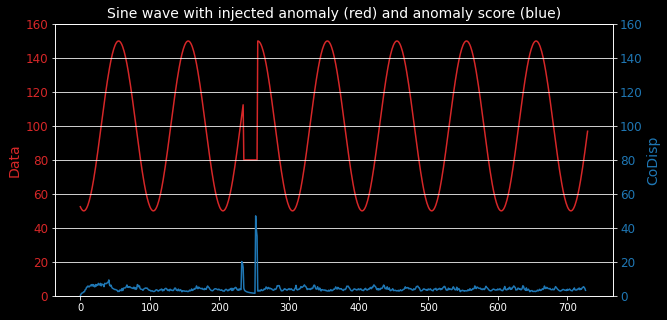

In [88]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax1 = plt.subplots(figsize=(10, 5))

color = 'tab:red'
ax1.set_ylabel('Data', color=color, size=14)
ax1.plot(sin, color=color)
ax1.tick_params(axis='y', labelcolor=color, labelsize=12)
ax1.set_ylim(0,160)
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('CoDisp', color=color, size=14)
ax2.plot(pd.Series(avg_codisp).sort_index(), color=color)
ax2.tick_params(axis='y', labelcolor=color, labelsize=12)
ax2.grid('off')
ax2.set_ylim(0, 160)
plt.title('Sine wave with injected anomaly (red) and anomaly score (blue)', size=14)

## Ch06-(1). 🎯 STL
___
* 정의
```
# 시계열 분해 : 시계열을 몇 가지 성분을 나누어 이해하는 작업 (※ trend, sesonality, cycle)
🕝 시계열 분해 역사
(1) Classical Decomposition : 전통적인 시계열 분해, MA 구할 시 앞뒤 데이터 삭제, Robust하지 못함
(2) X11 : 미국 인구 조사국/캐나다 통계청 개발, 양 끝점 삭제 해결, 휴일 효과 등 캘린더 고려, 갑작스런 변화에 유연하게 대응
(3) SEATS : 스페인 은행 개발, 분기별, 월별 데이터에서만 작동
(4) STL(Sesonal and Trend decompostion usinf Loess)
# 다양한 상황에서 사용할 수 있는 강력한 시계열 분해 기법
# SEAT와 X11과 다르게 월별, 분기별 데이터 포함 어떤 종류의 계절성도 다룰 수 있음
# 계절적인 성분이 시간에 따라 변해도 Hyper parameter를 통해 반영할 수 있음
# Trend와 Sesonality를 제거하고 남는 Residual을 활용하여 시계열 데이터 이상 탐지
```
<img src = "https://drive.google.com/uc?id=1sxpqeudcgqZ8hreIEe8e8-l_Qay6QRDl">
* 장단점
```
  # [good] 분기별, 월별, 일별 분해 모두 가능 
  # [good] MA(Moving Avg) 방식이 아니기 때문에 데이터 유실 없음
  # [good] 돌발스런 이상치에 대해 추세, 주기에 영향을 미치지 않음 
  # [bad] 캘린더 데이터를 반영하지 못함, 일별 데이터로 변환하여 넣어줘야함
  # [bad] 덧셈 분해 기능만 제공
```

* 덧셈 분해 (additive decomposition)  
 - y = S + T + R
```
 Trend가 일정함에 따라 변동폭이 동일하면 덧셈 분해(additive decomposition) 
 (※ Trend와 Seasonal의 관계가 없다.)
```
* 곱셈 분해 (multiplicative decomposition)  
 - y = S x T x R
```
  Trend가 상승함에 따라 변동폭이 변화하면 곱셈 분해(multiplicative decomposition)    
 (※ Trend변화에 따라 Seasonal의 관계가 있다.)
```  


* 사용방법
```
# !pip install statsmodels==0.12.1 (※ 오류 발생시 version 교체)
# from statsmodels.tsa.seasonal import STL
# 주기(Seasonal의) 결정
# Seasonal 및 Trend 제거 후 Residual 추출
# Residual 정규성 검증 및 3-sigma rule 적용 이상 탐지
```

* 현업사례
```
# 시계열(Time-series), 시간 종속 데이터 이상 탐지
```

### Ch06-(1). ✍ Toy data 실습
___

In [89]:
# ▶ Toy data 생성
import pandas as pd
co2 = [315.58,316.39,316.79,317.82,318.39,318.22,316.68,315.01,314.02,313.55,315.02,315.75,316.52,317.10,317.79,319.22,320.08,319.70,318.27,315.99,314.24,314.05,315.05,316.23,316.92,317.76,318.54,319.49,320.64,319.85,318.70,316.96,315.17,315.47,316.19,317.17,318.12,318.72,319.79,320.68,321.28,320.89,319.79,317.56,316.46,315.59,316.85,317.87,318.87,319.25,320.13,321.49,322.34,321.62,319.85,317.87,316.36,316.24,317.13,318.46,319.57,320.23,320.89,321.54,322.20,321.90,320.42,318.60,316.73,317.15,317.94,318.91,319.73,320.78,321.23,322.49,322.59,322.35,321.61,319.24,318.23,317.76,319.36,319.50,320.35,321.40,322.22,323.45,323.80,323.50,322.16,320.09,318.26,317.66,319.47,320.70,322.06,322.23,322.78,324.10,324.63,323.79,322.34,320.73,319.00,318.99,320.41,321.68,322.30,322.89,323.59,324.65,325.30,325.15,323.88,321.80,319.99,319.86,320.88,322.36,323.59,324.23,325.34,326.33,327.03,326.24,325.39,323.16,321.87,321.31,322.34,323.74,324.61,325.58,326.55,327.81,327.82,327.53,326.29,324.66,323.12,323.09,324.01,325.10,326.12,326.62,327.16,327.94,329.15,328.79,327.53,325.65,323.60,323.78,325.13,326.26,326.93,327.84,327.96,329.93,330.25,329.24,328.13,326.42,324.97,325.29,326.56,327.73,328.73,329.70,330.46,331.70,332.66,332.22,331.02,329.39,327.58,327.27,328.30,328.81,329.44,330.89,331.62,332.85,333.29,332.44,331.35,329.58,327.58,327.55,328.56,329.73,330.45,330.98,331.63,332.88,333.63,333.53,331.90,330.08,328.59,328.31,329.44,330.64,331.62,332.45,333.36,334.46,334.84,334.29,333.04,330.88,329.23,328.83,330.18,331.50,332.80,333.22,334.54,335.82,336.45,335.97,334.65,332.40,331.28,330.73,332.05,333.54,334.65,335.06,336.32,337.39,337.66,337.56,336.24,334.39,332.43,332.22,333.61,334.78,335.88,336.43,337.61,338.53,339.06,338.92,337.39,335.72,333.64,333.65,335.07,336.53,337.82,338.19,339.89,340.56,341.22,340.92,339.26,337.27,335.66,335.54,336.71,337.79,338.79,340.06,340.93,342.02,342.65,341.80,340.01,337.94,336.17,336.28,337.76,339.05,340.18,341.04,342.16,343.01,343.64,342.91,341.72,339.52,337.75,337.68,339.14,340.37,341.32,342.45,343.05,344.91,345.77,345.30,343.98,342.41,339.89,340.03,341.19,342.87,343.74,344.55,345.28,347.00,347.37,346.74,345.36,343.19,340.97,341.20,342.76,343.96,344.82,345.82,347.24,348.09,348.66,347.90,346.27,344.21,342.88,342.58,343.99,345.31,345.98,346.72,347.63,349.24,349.83,349.10,347.52,345.43,344.48,343.89,345.29,346.54,347.66,348.07,349.12,350.55,351.34,350.80,349.10,347.54,346.20,346.20,347.44,348.67,
400, 450, 460]
co2 = pd.Series(co2, index=pd.date_range("1-1-2022", periods=len(co2), freq="M"), name="CO2")
co2.head()

2022-01-31    315.58
2022-02-28    316.39
2022-03-31    316.79
2022-04-30    317.82
2022-05-31    318.39
Freq: M, Name: CO2, dtype: float64

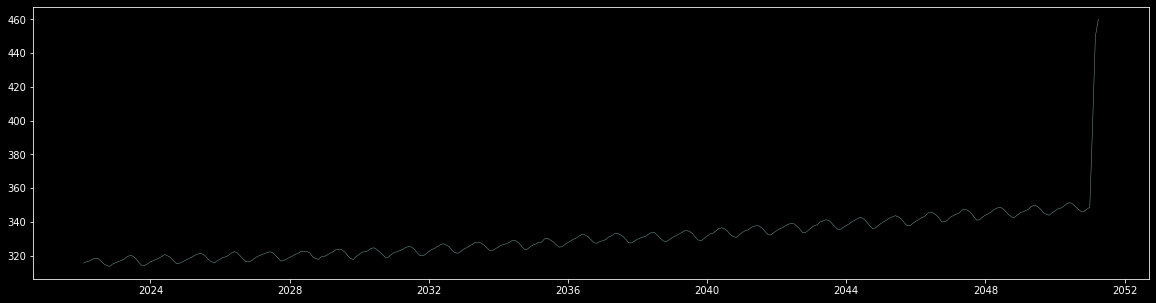

In [90]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use(['dark_background'])

# ▶ Plot
fig = plt.figure(figsize=(20,5))
plt.plot(co2, linewidth=0.5, alpha=0.75, label='Close');

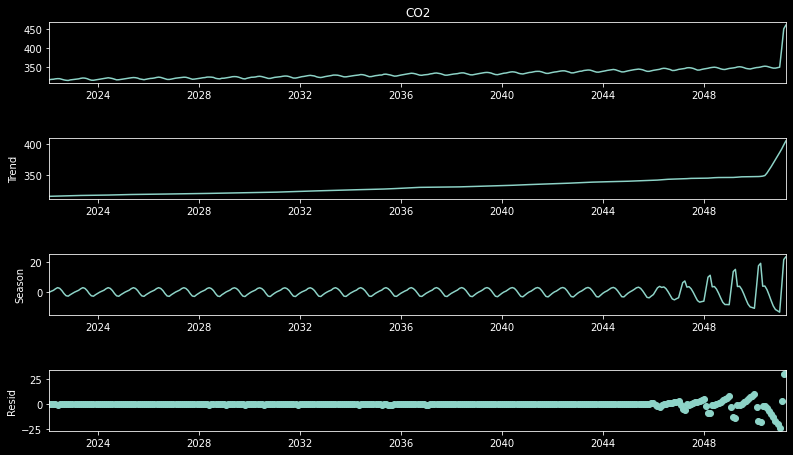

In [91]:
from statsmodels.tsa.seasonal import STL
# ▶ Odd num : seasonal = 13(연도별) / seasonal = 5(분기별) / seasonal = 7(주별)
stl = STL(co2, seasonal=13)
res = stl.fit()
fig = res.plot()
fig.set_size_inches(12, 7)

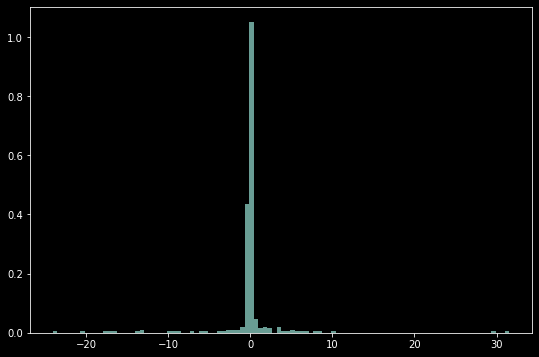

In [92]:
# ▶ Residual(잔차)의 분포 확인
fig, ax = plt.subplots(figsize=(9,6))
_ = plt.hist(res.resid, 100, density=True, alpha=0.75)

In [93]:
# ▶ Ztest를 통한 정규성 검증(Nomality Test)
# ▶ Ztest : 정규분포를 가정하며, 추출된 표본이 동일 모집단(정규분포)에 속하는지 가설 검증하기 위해 사용 (※ p-value가 0.05 이상이면 정규성을 따름)
from statsmodels.stats.weightstats import ztest
r = res.resid.values
st, p = ztest(r)
print(st,p)  

-0.6506146684262828 0.5152952591180103


In [94]:
# ▶ 평균과 표준편차 출력
mu, std = res.resid.mean(), res.resid.std()
print("평균:", mu, "표준편차:", std)

# 3-sigma(표준편차)를 기준으로 이상치 판단
print("이상치 갯수:", len(res.resid[(res.resid>mu+3*std)|(res.resid<mu-3*std)]))
# 이상치 갯수: 10

평균: -0.13473483767402747 표준편차: 3.879802434937742
이상치 갯수: 10


In [95]:
# ▶ 이상 데이터 확인
co2[res.resid[(res.resid>mu+3*std)|(res.resid<mu-3*std)].index]

2049-02-28    346.72
2049-03-31    347.63
2050-02-28    348.07
2050-03-31    349.12
2050-09-30    346.20
2050-10-31    346.20
2050-11-30    347.44
2050-12-31    348.67
2051-02-28    450.00
2051-03-31    460.00
Name: CO2, dtype: float64

In [96]:
# ▶ 이상 데이터 위치 확인
co2_df = co2.reset_index()
print(co2_df[co2_df['index'] == '2049-02-28'].index)
print(co2_df[co2_df['index'] == '2049-03-31'].index)
print(co2_df[co2_df['index'] == '2050-02-28'].index)
print(co2_df[co2_df['index'] == '2050-03-31'].index)
print(co2_df[co2_df['index'] == '2050-09-30'].index)
print(co2_df[co2_df['index'] == '2050-10-31'].index)
print(co2_df[co2_df['index'] == '2050-11-30'].index)
print(co2_df[co2_df['index'] == '2050-12-31'].index)
print(co2_df[co2_df['index'] == '2051-02-28'].index)
print(co2_df[co2_df['index'] == '2051-03-31'].index)

Int64Index([325], dtype='int64')
Int64Index([326], dtype='int64')
Int64Index([337], dtype='int64')
Int64Index([338], dtype='int64')
Int64Index([344], dtype='int64')
Int64Index([345], dtype='int64')
Int64Index([346], dtype='int64')
Int64Index([347], dtype='int64')
Int64Index([349], dtype='int64')
Int64Index([350], dtype='int64')


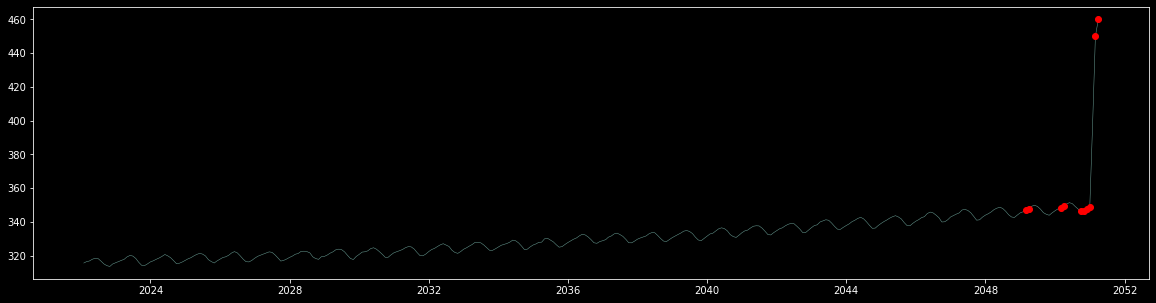

In [97]:
# ▶ Plot
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use(['dark_background'])
fig = plt.figure(figsize=(20,5))

plt.plot(co2, linewidth=0.5, alpha=0.75, label='Close');
plt.plot(co2, 'or', markevery=[325, 326, 337, 338, 344, 345, 346, 347, 349, 350]);

## Ch06-(2). 🎯 Holt-winters
___
* 정의
```
# STL은 강력한 시계열 분해 방법이지만, 지속적으로 증가하는(multiplicative) 이상 Point 탐지에 대해서 약점을 가지고 있음
# 가까운 데이터는 가중치를 높게 할당하고 오래전 데이터는 가중치를 작게 할당 하여 미래의 x값을 예측
# exponential smoothing(지수평활) 기법
# Holt-Winters 알고리즘은 단순한 exponential smoothing 뿐만 아니라 trend 속성과 seasonality 속성이 추가
# Holt-Winters를 활용해 시계열 데이터를 예측하고, brutlag 알고리즘 활용 신뢰구간을 설정하여 이상 탐지
# Holt-Winters 모델은 단순하면서도 널리 활용되어지는 시계열 분석도구로서 많은 시계열예측의 기준모델로서 쓰이고 있음
```
<img src = "https://drive.google.com/uc?id=1WqLGazewaYeW_HlMq4jse-_TPngRKBRq">

* 장단점
```
  # [good] 장기간 예측이 가능
  # [good] Hyper parameter 조정을 통해 이상 허용 오차에 대해 유연하게 대응
  # [good] 연산량이 적음, 큰 데이터 세트에 대해서 리소스 절약, 자동화 가능
  # [good] 계절성을 고려한 이상 탐지 가능 
  # [bad] 단변량 데이터에 대해서만 적용 가능, 상관관계 고려 X
  # [bad] 계절성이 없는 데이터에 대해서는 성능 저조
  # [bad] 변동이 적은 계절성 데이터에 대해서는 민감하게 탐지할 우려
```

* 사용방법
```
# from statsmodels.tsa.holtwinters import ExponentialSmoothing
# ES(Exponential Smoothing)을 통해 전체 데이터셋을 학습하고 예측
# Brutlag Algorithm 활용 신뢰구간 설정
# 신뢰구간 활용 이상 Point 탐지
```

* 현업사례
```
# 시계열(Time-series), 시간 종속 데이터 수요 예측 및 이상 탐지
```

### Ch06-(2). ✍ Toy data 실습
___

In [98]:
import pandas as pd
co2 = [315.58,316.39,316.79,317.82,318.39,318.22,316.68,315.01,314.02,313.55,315.02,315.75,316.52,317.10,317.79,319.22,320.08,319.70,318.27,315.99,314.24,314.05,315.05,316.23,316.92,317.76,318.54,319.49,320.64,319.85,318.70,316.96,315.17,315.47,316.19,317.17,318.12,318.72,319.79,320.68,321.28,320.89,319.79,317.56,316.46,315.59,316.85,317.87,350, 318.87,319.25,320.13,321.49,322.34,321.62,319.85,317.87,316.36,316.24,317.13,318.46,319.57,320.23,320.89,321.54,322.20,321.90,320.42,318.60,316.73,317.15,317.94,318.91,319.73,320.78,321.23,322.49,322.59,322.35,321.61,319.24,318.23,317.76,319.36,319.50,320.35,321.40,322.22,323.45,323.80,323.50,322.16,320.09,318.26,317.66,319.47,320.70,322.06,322.23,322.78,324.10,324.63,323.79,322.34,320.73,319.00,318.99,320.41,321.68,322.30,322.89,323.59,324.65,325.30,325.15,323.88,321.80,319.99,319.86,320.88,322.36,323.59,324.23,325.34,326.33,327.03,326.24,325.39,323.16,321.87,321.31,322.34,323.74,324.61,325.58,326.55,327.81,327.82,327.53,326.29,324.66,323.12,323.09,324.01,325.10,326.12,326.62,327.16,327.94,329.15,328.79,327.53,325.65,323.60,323.78,325.13,326.26,326.93,327.84,327.96,329.93,330.25,329.24,328.13,326.42,324.97,325.29,326.56,327.73,328.73,329.70,330.46,331.70,332.66,332.22,331.02,329.39,327.58,327.27,328.30,328.81,329.44,330.89,331.62,332.85,333.29,332.44,331.35,329.58,327.58,327.55,328.56,329.73,330.45,330.98,331.63,332.88,333.63,333.53,331.90,330.08,328.59,328.31,329.44,330.64,331.62,332.45,333.36,334.46,334.84,334.29,333.04,330.88,329.23,328.83,330.18,331.50,332.80,333.22,334.54,335.82,336.45,335.97,334.65,332.40,331.28,330.73,332.05,333.54,334.65,335.06,336.32,337.39,337.66,337.56,336.24,334.39,332.43,332.22,333.61,334.78,335.88,336.43,337.61,338.53,339.06,338.92,337.39,335.72,333.64,333.65,335.07,336.53,337.82,338.19,339.89,340.56,341.22,340.92,339.26,337.27,335.66,335.54,336.71,337.79,338.79,340.06,340.93,342.02,342.65,341.80,340.01,337.94,336.17,336.28,337.76,339.05,340.18,341.04,342.16,343.01,343.64,342.91,341.72,339.52,337.75,337.68,339.14,340.37,341.32,342.45,343.05,344.91,345.77,345.30,343.98,342.41,339.89,340.03,341.19,342.87,343.74,344.55,345.28,347.00,347.37,346.74,345.36,343.19,340.97,341.20,342.76,343.96,344.82,345.82,347.24,348.09,348.66,347.90,346.27,344.21,342.88,342.58,343.99,345.31,345.98,346.72,347.63,349.24,349.83,349.10,347.52,345.43,344.48,343.89,345.29,346.54,347.66,360.07,349.12,350.55,351.34,350.80,349.10,320.54,346.20,346.20,347.44,348.67]
co2 = pd.Series(co2, index=pd.date_range("1-1-2022", periods=len(co2), freq="M"), name="CO2")
co2 = pd.DataFrame(co2)
co2.head()

,CO2
2022-01-31,315.58
2022-02-28,316.39
2022-03-31,316.79
2022-04-30,317.82
2022-05-31,318.39


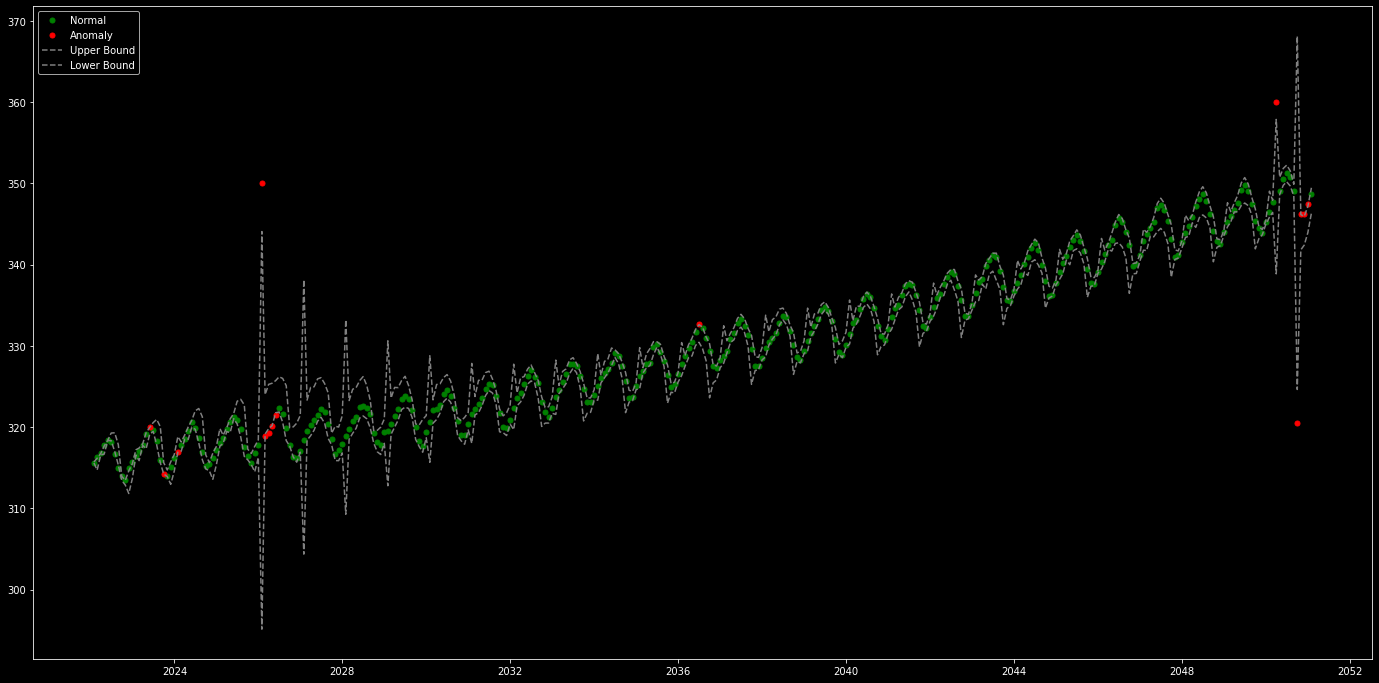

In [99]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

temp_df = co2
train_df = co2

# ▶ ES 모델을 만들어 학습하고 전체 데이터에 대해 예측한다.
# ▶ additive는 경향성이 일정함을 의미하고, 경향성 변동폭이 있을 때는 multiplicative를 사용
model = ExponentialSmoothing(
    train_df, trend='additive', seasonal='additive').fit()
    
prediction = model.predict(
    start=temp_df.index[0], end=temp_df.index[-1])

"""Brutlag Algorithm"""
PERIOD = 12        # The given time series has seasonal_period=12
GAMMA = 0.4        # the seasonility component
SF = 1.96          # brutlag scaling factor for the confidence bands.
UB = []            # upper bound or upper confidence band
LB = []            # lower bound or lower confidence band

# ▶ 실측치와 예측치를 비교하는 자료구조
difference_array = []
dt = []
difference_table = {"actual": temp_df, "predicted": prediction, "difference": difference_array, "UB": UB, "LB": LB}

# ▶ brutlag 알고리즘
# ▶ 12개월 이전의 실측/결측 차이에 0.6, 이번달 차이에 0.4 정도의 가중치를 주어 저장
for i in range(len(prediction)):
    diff = temp_df.iloc[i]-prediction.iloc[i]
    if i < PERIOD:
        dt.append(GAMMA*abs(diff))
    else:
        dt.append(GAMMA*abs(diff) + (1-GAMMA)*dt[i-PERIOD])

# ▶ 저장된 실측/결측 차이를 예측치의 95% 신뢰구간(1.96)으로 반영하여 Upper/Lower Band 계산
    difference_array.append(diff)
    UB.append(prediction[i]+SF*dt[i])
    LB.append(prediction[i]-SF*dt[i])
    
"""Classification of data points as either normal or anomaly"""
normal = []
normal_date = []
anomaly = []
anomaly_date = []

# 신뢰구간을 벗어나는지 판단하여 normal, anomaly 결정
for i in range(len(temp_df.index)):
    if ((UB[i] <= temp_df.iloc[i]).bool() or (LB[i] >= temp_df.iloc[i]).bool()) and i > PERIOD:
        anomaly_date.append(temp_df.index[i])
        anomaly.append(temp_df.iloc[i][0])
    else:
        normal_date.append(temp_df.index[i])
        normal.append(temp_df.iloc[i][0])
        
anomaly = pd.DataFrame({"date": anomaly_date, "value": anomaly})
anomaly.set_index('date', inplace=True)
normal = pd.DataFrame({"date": normal_date, "value": normal})
normal.set_index('date', inplace=True)

# plotting
plt.figure(figsize=(24,12))
plt.plot(normal.index, normal, 'o', color='green', markersize=5)
plt.plot(anomaly.index, anomaly, 'o', color='red', markersize=5)
plt.plot(temp_df.index, UB, linestyle='--', color='grey')
plt.plot(temp_df.index, LB, linestyle='--', color='grey')
plt.legend(['Normal', 'Anomaly', 'Upper Bound', 'Lower Bound'])
plt.show()

In [100]:
# 이상 데이터 확인
anomaly

,value
date,
2023-05-31,320.08
2023-09-30,314.24
2024-01-31,316.92
2026-01-31,350.00
2026-02-28,318.87
2026-03-31,319.25
2026-04-30,320.13
2026-05-31,321.49
2036-06-30,332.66
